In [1]:
import pymongo
import pandas as pd
import numpy as np
from scipy import stats
import pytz
import datetime
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
import matplotlib
from matplotlib import font_manager
import seaborn as sns
import statsmodels.api as sm

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
# sns.set_context('talk')

# Data Selection: from December 1, 2019 to November 30, 2020

In [2]:
HKT = pytz.timezone('Asia/Hong_Kong')
start = HKT.localize(datetime.datetime(2019, 12, 1) )
end = HKT.localize(datetime.datetime(2020, 12, 1) )

In [3]:
try:
    # password authentication to login to MongoDB
    client = pymongo.MongoClient(
        host='localhost',
        port=27018,
        username='----USERNAME_REMOVED----',
        password='----PASSWORD_REMOVED----',
        authSource='OpenupDB',
        authMechanism='SCRAM-SHA-256',
    )

    # access Openup Database and authenticate
    db = client['OpenupDB']

    
    df_risklevels = pd.DataFrame(
        list(db['data_management_risklevelchange'].find({
        '$and': [           
            { 'startDateTime': { '$gte': start } },
            { 'startDateTime': { '$lt': end } },
        ] } )  
    ) )
    
#     df_identifiers = pd.DataFrame(
#         list(db['data_management_identifierlist'].find()  
#     ) )
    
#     df_counsellor_cases = pd.DataFrame(
#         list(db['data_management_counsellorcases'].find({
#         '$and': [
#             {'uuid': { '$in': df_risklevels['uuid'].to_list() } },
#         ] } ) 
#     ) )
    
    client.close()
            

except:
    print('Cannot access OpenUp database.')
    if client:
        client.close()

## adjust time (UTC to HKT)

In [4]:
for col in df_risklevels.columns:
    if 'time' in col.lower():
#         print(col)
        df_risklevels[col] = df_risklevels[col] + pd.Timedelta('8h')
    
# for col in df_counsellor_cases.columns:
#     if 'time' in col.lower():
#         df_counsellor_cases[col] = df_counsellor_cases[col] + pd.Timedelta('8h')

In [5]:
df_risklevels['incoming'] = df_risklevels['pingpongCount'].apply(
    lambda x: 'valid-case' if x >=4 else 'invalid-case')

df_risklevels['hour'] = df_risklevels['startDateTime'].dt.hour

df_risklevels['month'] = df_risklevels['startDateTime'].dt.month
df_risklevels['week'] = df_risklevels['startDateTime'].dt.isocalendar().week

df_risklevels['year'] = df_risklevels['startDateTime'].dt.year

df_risklevels['startdate'] = df_risklevels['startDateTime'].dt.round('H')
df_risklevels['enddate'] = df_risklevels['endDateTime'].dt.round('H')

df_risklevels['day_of_week'] = df_risklevels['startDateTime'].dt.day_name()
df_risklevels['day_int'] = df_risklevels['startDateTime'].dt.weekday
df_risklevels['date'] = df_risklevels['startDateTime'].dt.date

In [6]:
df_risklevels['maxRiskLevel'].replace({
    'HIGH': 'HIGH or CRISIS', 
    'CRISIS': 'HIGH or CRISIS'
}, inplace=True)

# 1. Weekday count (52 weeks 354 days)

In [7]:
week_52 = df_risklevels[
    (df_risklevels['startDateTime']>=datetime.datetime(2019, 12, 2)) & 
    (df_risklevels['startDateTime']<datetime.datetime(2020, 11, 30))
].copy()

In [8]:
weekly_data = pd.crosstab(
    [week_52['date'], week_52['week'], week_52['day_int']], 
    week_52['tos_status']
).reset_index().drop(
    columns=['not_accepted', 'date'])

In [9]:
weekly_data = pd.pivot_table(
    weekly_data, values='accepted', index=['week'],
    columns=['day_int'], aggfunc=np.sum
)

In [10]:
weekly_data = pd.concat([weekly_data[-4:], weekly_data[:-4]])

In [11]:
weekly_data.reset_index(drop=True, inplace=True)

In [12]:
weekly_percent = weekly_data.divide(
    weekly_data.sum(axis=1), axis=0)

In [13]:
weekly_data

day_int,0,1,2,3,4,5,6
0,126,114,128,147,119,156,139
1,141,123,142,137,129,165,158
2,164,154,132,105,88,127,94
3,111,71,84,86,144,157,114
4,173,98,100,84,160,120,127
5,158,98,95,111,129,98,88
6,123,130,118,162,106,125,144
7,113,82,127,105,93,113,88
8,105,90,92,117,114,125,91
9,91,90,99,102,107,102,146


In [14]:
agg_28_days = weekly_data.groupby(weekly_data.index//4).sum()
agg_28_days.index.name = None

In [15]:
agg_28_days

day_int,0,1,2,3,4,5,6
0,542,462,486,475,480,605,505
1,567,408,440,462,488,456,447
2,444,445,496,503,520,609,558
3,590,585,557,605,597,545,524
4,506,517,530,503,449,491,533
5,644,586,561,640,621,611,659
6,656,659,797,669,615,602,622
7,721,601,679,727,708,648,682
8,818,913,715,776,765,720,846
9,884,772,839,848,877,796,844


In [16]:
weekly_percent

day_int,0,1,2,3,4,5,6
0,0.135630,0.122713,0.137783,0.158235,0.128095,0.167922,0.149623
1,0.141709,0.123618,0.142714,0.137688,0.129648,0.165829,0.158794
2,0.189815,0.178241,0.152778,0.121528,0.101852,0.146991,0.108796
3,0.144720,0.092568,0.109518,0.112125,0.187744,0.204694,0.148631
4,0.200696,0.113689,0.116009,0.097448,0.185615,0.139211,0.147332
5,0.203346,0.126126,0.122265,0.142857,0.166023,0.126126,0.113256
6,0.135463,0.143172,0.129956,0.178414,0.116740,0.137665,0.158590
7,0.156727,0.113731,0.176144,0.145631,0.128988,0.156727,0.122053
8,0.143052,0.122616,0.125341,0.159401,0.155313,0.170300,0.123978
9,0.123474,0.122117,0.134328,0.138399,0.145183,0.138399,0.198100


In [17]:
agg_28_days.divide(agg_28_days.sum(axis=1), axis=0)

day_int,0,1,2,3,4,5,6
0,0.152461,0.129958,0.136709,0.133615,0.135021,0.170183,0.142053
1,0.173501,0.124847,0.134639,0.141371,0.149327,0.139535,0.136781
2,0.124196,0.124476,0.138741,0.140699,0.145455,0.170350,0.156084
3,0.147389,0.146140,0.139146,0.151137,0.149138,0.136148,0.130902
4,0.143383,0.146500,0.150184,0.142533,0.127232,0.139133,0.151034
5,0.149005,0.135585,0.129801,0.148080,0.143683,0.141370,0.152476
6,0.141991,0.142641,0.172511,0.144805,0.133117,0.130303,0.134632
7,0.151280,0.126102,0.142467,0.152539,0.148552,0.135963,0.143097
8,0.147308,0.164416,0.128759,0.139744,0.137763,0.129660,0.152350
9,0.150853,0.131741,0.143174,0.144710,0.149659,0.135836,0.144027


In [18]:
agg_28_days[3:7].sum()/agg_28_days[3:7].sum().sum()

day_int
0    0.145441
1    0.142467
2    0.148416
3    0.146716
4    0.138521
5    0.136518
6    0.141921
dtype: float64

<AxesSubplot:xlabel='day_int'>

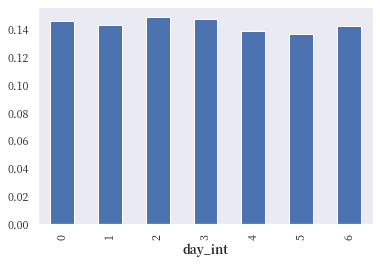

In [19]:
(agg_28_days[3:7].sum()/agg_28_days[3:7].sum().sum()).plot.bar()

# observations:
## 1. positive correlations between weekdays
## 2. higher correlation with previous day
## 3. can try to model the weekly seasonal pattern

<AxesSubplot:xlabel='day_int'>

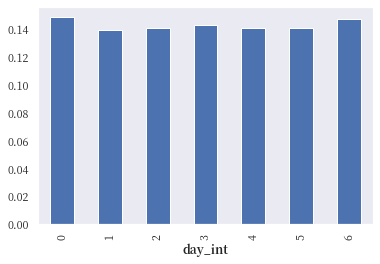

In [20]:
(weekly_data.sum()/weekly_data.sum().sum()).plot.bar()

In [21]:
(weekly_data.sum()/weekly_data.sum().sum())

day_int
0    0.148704
1    0.139136
2    0.140706
3    0.143118
4    0.140625
5    0.140399
6    0.147312
dtype: float64

In [22]:
stats.kruskal(
    weekly_percent[1],
    weekly_percent[2],
    weekly_percent[3],
    weekly_percent[4],
    weekly_percent[5],
)

KruskalResult(statistic=2.241277545234882, pvalue=0.6914797437709966)

In [23]:
stats.kruskal(
    weekly_percent[0],
    weekly_percent[6],
)

KruskalResult(statistic=0.15726965342349786, pvalue=0.6916828226936153)

In [24]:
stats.kruskal(
    pd.concat([weekly_percent[0], weekly_percent[6]]),
    pd.concat([
        weekly_percent[1],
        weekly_percent[2],
        weekly_percent[3],
        weekly_percent[4],
        weekly_percent[5]])
)

KruskalResult(statistic=7.493091210114638, pvalue=0.006193614561807616)

In [25]:
import pingouin as pg

In [26]:
weekly_data.rcorr(
    method='spearman', padjust='holm'
)

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


day_int,0,1,2,3,4,5,6
day_int,,,,,,,
0,-,***,***,***,***,***,***
1,0.764,-,***,***,***,***,***
2,0.693,0.821,-,***,***,***,***
3,0.61,0.704,0.796,-,***,***,***
4,0.721,0.71,0.77,0.78,-,***,***
5,0.703,0.689,0.708,0.688,0.784,-,***
6,0.755,0.746,0.755,0.738,0.798,0.822,-


In [27]:
df_risklevels.columns

Index(['_id', 'pingpongCount', 'startDateTime', 'status', 'uuid',
       'endQueueTime', 'endDateTime', 'summary', 'helpseeker', 'identifier',
       'firstRiskLevel', 'maxRiskLevel', 'exitRiskLevel', 'numAudits',
       'duration', 'chatbotTriaged', 'repeated_user', 'community_referral',
       'connectednesscare_sent', 'helpseeker_alias', 'counsellor',
       'tos_status', 'gender', 'age', 'issues', 'counsellor_firstRiskLevel',
       'chatbot_audit_count', 'counsellor_audit_count', 'referral',
       'safetyplan', 'chatbot_firstRiskLevel', 'superceded_chatbot_RiskLevel',
       'incoming', 'hour', 'month', 'week', 'year', 'startdate', 'enddate',
       'day_of_week', 'day_int', 'date'],
      dtype='object')

# 2. tos status

## overall percentage

In [28]:
df_risklevels['tos_status'].count()

83013

In [29]:
df_risklevels['tos_status'].value_counts()

accepted        62081
not_accepted    20932
Name: tos_status, dtype: int64

In [30]:
df_risklevels['tos_status'].value_counts(normalize=True)

accepted        0.747847
not_accepted    0.252153
Name: tos_status, dtype: float64

## tos status by hour

In [31]:
tos_state = df_risklevels.groupby(
    ['tos_status', 'hour'])[['_id']].count().reset_index().pivot(
    index='hour', columns='tos_status', values='_id')

In [32]:
tos_state['all'] = tos_state.sum(axis=1)

In [33]:
tos_state_ratio = tos_state.divide(tos_state['all'], axis=0)

In [34]:
# tos_state_ratio.drop(columns=['all'])

In [35]:
def plot_tos_status_breakdown(by):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8) )
    palette = 'Set2'

    sns.kdeplot(
        data=df_risklevels, x=by, hue='tos_status',
        multiple='fill',
        ax=ax1,
        palette=palette
    )
    # overwrite existing label
    ax1.set_ylabel('Probability')
    
    if by == 'hour':
        ax1.set_xlim(0, 24)
    
    elif by == 'startDateTime_floor':
        ax1.set_xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 11, 1, 23) )

    sns.histplot(
        data=df_risklevels, x=by, hue='tos_status',
        discrete=True,
        multiple='dodge', 
        ax=ax2,
        palette=palette
    )
    

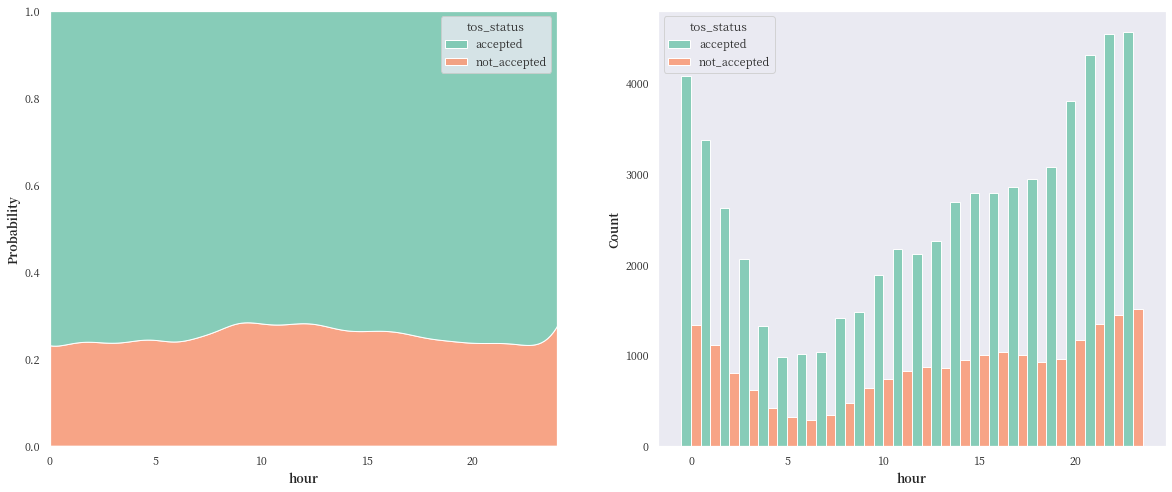

In [36]:
plot_tos_status_breakdown('hour')

## in 2 hour intervals: stationary most of the time  

In [37]:
df_risklevels['startDateTime_floor'] = df_risklevels['startDateTime'].dt.floor('2h')

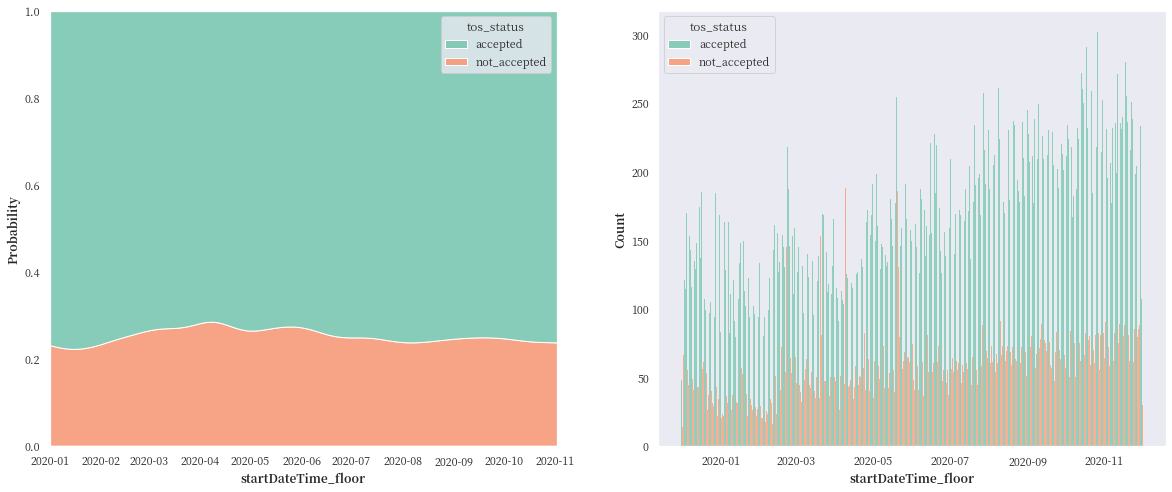

In [38]:
plot_tos_status_breakdown('startDateTime_floor')

## Acceptance is about 75%. We can probably model this as a Bernoulli Process

# 3. check the service duration distribution

## 3.1 Service duration by hour?

In [39]:
df_risklevels[
    (df_risklevels['pingpongCount'] >= 10) &
    (df_risklevels['incoming'] =='valid-case')
].groupby('hour')['duration'].describe(percentiles=[.5,])

,count,mean,std,min,50%,max
hour,,,,,,
0,1833.0,61.820950,38.568197,4.581900,54.318833,419.001317
1,1436.0,63.087724,37.675376,4.743883,55.635625,323.578017
2,1101.0,62.645340,37.510370,5.165500,54.023983,283.346833
3,819.0,59.514248,34.862781,4.167300,52.738050,307.468950
4,619.0,58.987943,32.443890,3.582417,53.000583,186.822967
5,437.0,54.545744,35.456331,4.772683,47.444367,392.711000
6,410.0,46.002452,31.922930,7.773033,40.094300,319.292200
7,493.0,60.316452,39.885958,5.033250,52.099800,289.624117
8,749.0,55.512613,36.497765,4.956683,48.112817,220.457900


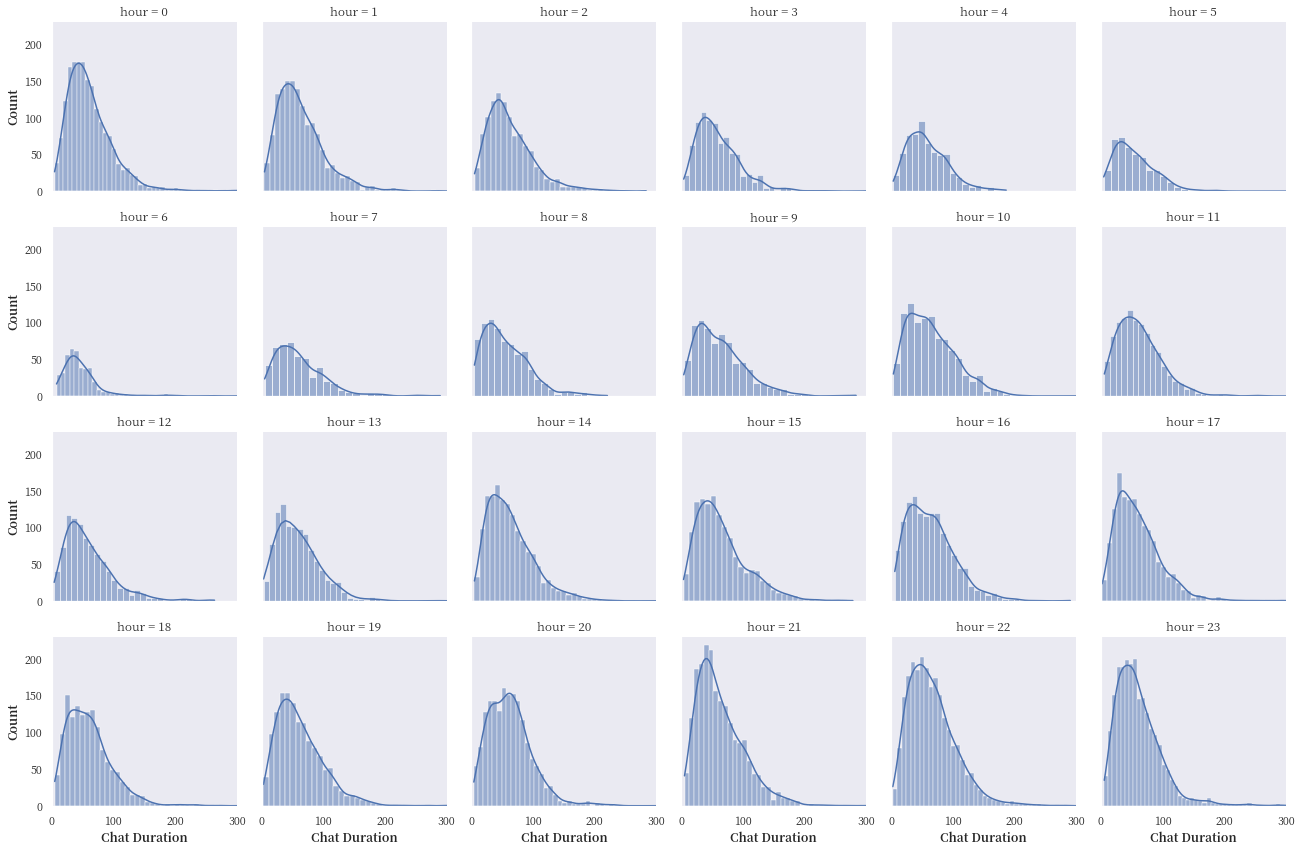

In [40]:
g = sns.FacetGrid(
    df_risklevels[
        (df_risklevels['incoming'] =='valid-case') &
        (df_risklevels['pingpongCount'] >= 10)
    ],
    col='hour',
    height=3, aspect=1,
    sharey=True,
    sharex=True,
    col_wrap=6,
    xlim=(0, 300),
)
g.map(sns.histplot, 'duration', kde=True )
g.set_axis_labels('Chat Duration', 'Count')

<AxesSubplot:xlabel='duration', ylabel='Density'>

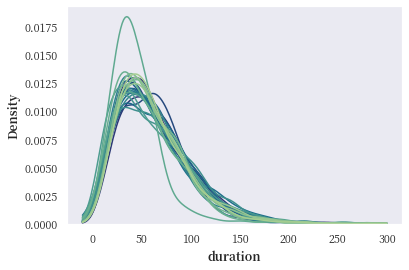

In [41]:
sns.kdeplot(data=df_risklevels[
        (df_risklevels['incoming'] =='valid-case') &
        (df_risklevels['pingpongCount'] >= 10)
    ],
    x='duration',
    hue='hour',
    palette='crest',
    clip=(-10, 300),
    legend=False,
    common_norm=False,
)

## In most cases the KDE is right skewed (positive), resembling a Beta distribution.  Also graphically and from the descriptive stats, the chat duration by hour varies very little

# Some difference between risk groups in terms of duration and pingpong count

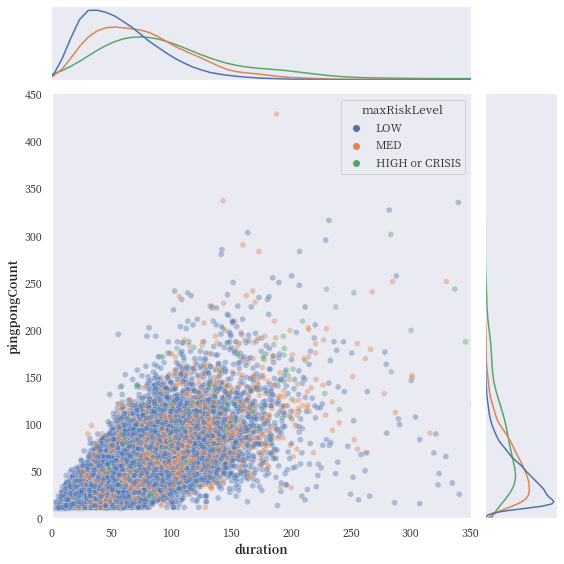

In [42]:
g = sns.JointGrid(
    data=df_risklevels[
        (df_risklevels['incoming'] =='valid-case') &
        (df_risklevels['pingpongCount'] >= 10)
    ],
    x='duration',
    y='pingpongCount',
    hue='maxRiskLevel',
    xlim=(0, 350),
    ylim=(0, 450),
    height=8
)

g.plot_joint(sns.scatterplot, alpha=.4)
g.plot_marginals(sns.kdeplot, common_norm=False, common_grid=True)

## 3.1 Service Duration by risk?

In [43]:
valid_cases = df_risklevels[
    (df_risklevels['incoming'] =='valid-case')
]

In [44]:
valid_cases['maxRiskLevel'].value_counts()

LOW               31198
MED                3628
HIGH or CRISIS      229
Name: maxRiskLevel, dtype: int64

In [45]:
valid_cases['maxRiskLevel'].value_counts(normalize=True)

LOW               0.889973
MED               0.103495
HIGH or CRISIS    0.006533
Name: maxRiskLevel, dtype: float64

In [46]:
def generate_duration_stats(df, drop_outliers=False):
    df1 = df.groupby('maxRiskLevel')['duration'].describe(percentiles=[.5,])
    df1.sort_values(by=['count'], ascending=False, inplace=True)
    df2 = df[['duration']].describe(percentiles=[.5,]).rename(
        columns={'duration':'All cases'}).T
    return pd.concat([df1, df2], axis=0)

In [47]:
generate_duration_stats(valid_cases)

,count,mean,std,min,50%,max
LOW,31198.0,53.529577,40.302789,0.768033,45.622658,1418.695283
MED,3628.0,75.155410,45.363259,2.569267,68.493217,559.678433
HIGH or CRISIS,229.0,102.666885,69.369598,11.009767,85.626450,575.214950
All cases,35055.0,56.088726,41.802375,0.768033,47.908817,1418.695283


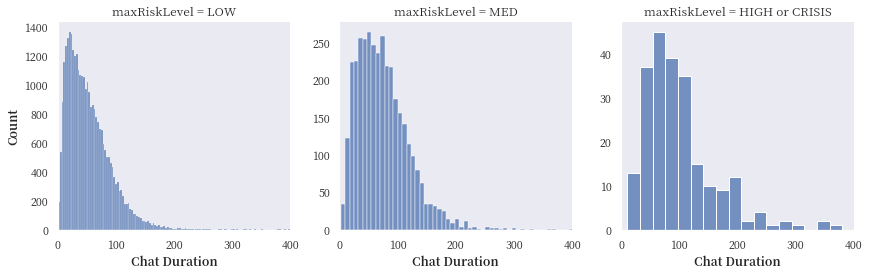

In [48]:
g = sns.FacetGrid(
    valid_cases,
    col='maxRiskLevel',
    height=4, aspect=1,
    sharey=False,
    sharex=True,
    xlim=(0, 400),
)
g.map(sns.histplot, 'duration' )
g.set_axis_labels('Chat Duration', 'Count')

## remove outliers

In [49]:
def remove_outliers(df, col, mul=1.5):
    desc_stats = df[col].describe()
    iqr = mul * (desc_stats['75%'] - desc_stats['25%'])
    lower = desc_stats['25%'] - iqr
    upper = desc_stats['75%'] + iqr
    return df[(df[col]>=lower) & (df[col]<=upper)]

In [50]:
cleaned_duration_low = remove_outliers(
    valid_cases[
        (valid_cases['maxRiskLevel'] =='LOW')
    ], 'duration'
)

cleaned_duration_med = remove_outliers(
    valid_cases[
        (valid_cases['maxRiskLevel'] =='MED')
    ], 'duration'
)

cleaned_duration_high_crisis = remove_outliers(
    valid_cases[
        (valid_cases['maxRiskLevel'] =='HIGH or CRISIS')
    ], 'duration'
)

## difference is observed (kruskal wallis p << 0.05) - three different types of duration

In [51]:
stats.kruskal(
    cleaned_duration_med['duration'],
    cleaned_duration_low['duration'],
    cleaned_duration_high_crisis['duration'],
)

KruskalResult(statistic=1210.5999578152837, pvalue=1.3229982333454874e-263)

## duration by risk, with outliers removed

In [52]:
cleaned_duration = pd.concat([
    cleaned_duration_low,
    cleaned_duration_med,
    cleaned_duration_high_crisis])

In [53]:
generate_duration_stats(cleaned_duration)

,count,mean,std,min,50%,max
LOW,30486.0,50.211574,31.644800,0.768033,44.546925,145.413783
MED,3556.0,71.952733,38.866986,2.569267,67.183642,186.309450
HIGH or CRISIS,218.0,92.019042,47.317836,11.009767,83.181683,228.139000
All cases,34260.0,52.734213,33.404176,0.768033,46.764350,228.139000


## check QQ plots

In [54]:
def check_qq_plot(data):
    distributions = [
        'beta',
        'expon',
        'gamma',
        'lognorm',
        'pearson3',
        'triang',
        'uniform',
        'weibull_min', 
        'pareto'
    ]
    
    fig, ax = plt.subplots(3 , 3, figsize=(10, 10) )
    
    for i, d in enumerate(distributions):
        dist = getattr(stats, d)
        sm.qqplot(data, dist, fit=True, 
            line='45', ax=ax[i//3][i%3])
        ax[i//3][i%3].set_title(f'distribution: {d}')
    
    plt.tight_layout()
    plt.show()

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


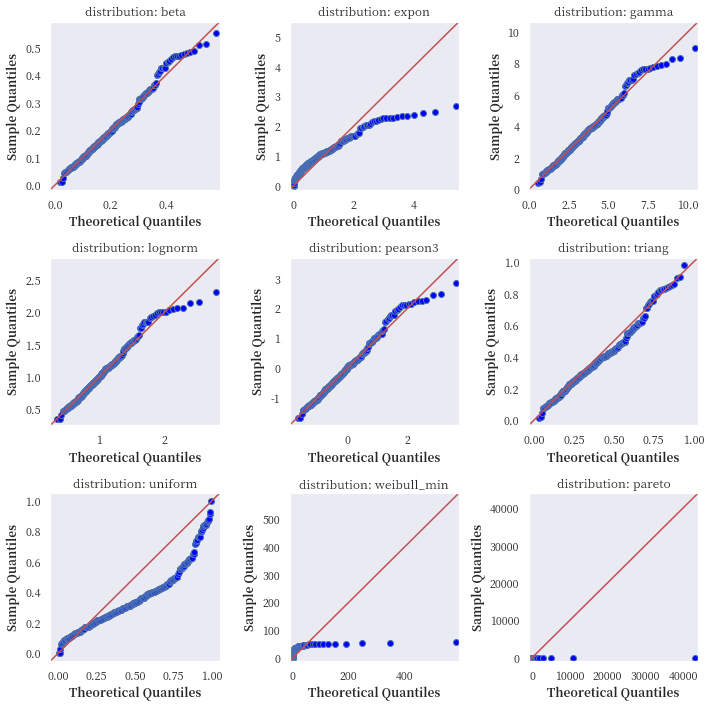

In [55]:
check_qq_plot(cleaned_duration_high_crisis['duration'])

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


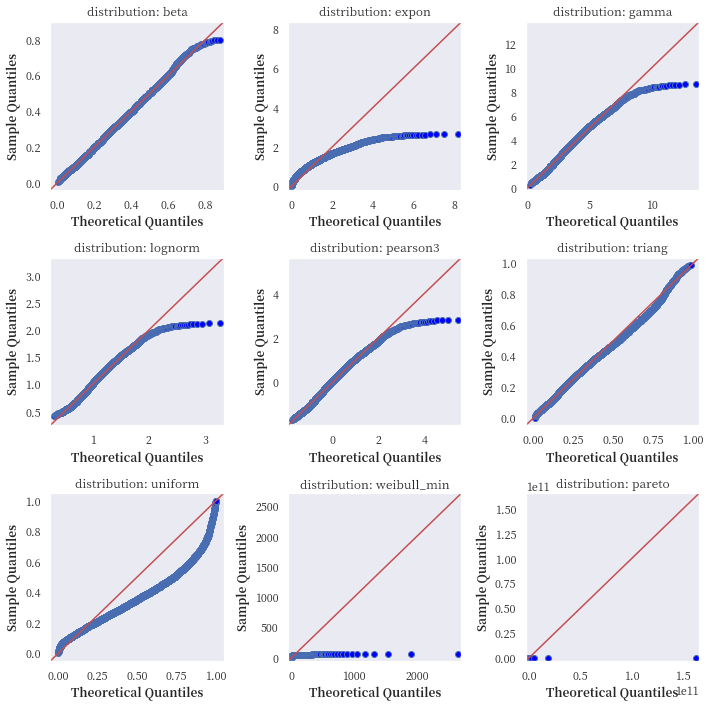

In [56]:
check_qq_plot(cleaned_duration_med['duration'])

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


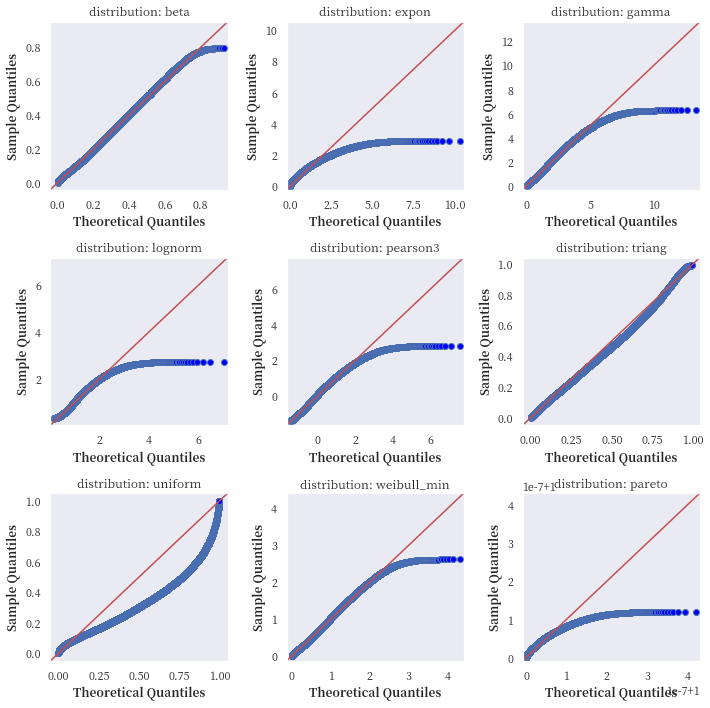

In [57]:
check_qq_plot(cleaned_duration_low['duration'])

## duration can be modelled using beta or triangular distribution

In [58]:
def plot_fitted_distributions(y, distributions, num_pts, bins=50, floc=None):
    fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

    sns.histplot(
        y,
        stat='density',
        ax=ax,
        bins=bins,
        color='red',
        alpha=.2
    )
    
    x = np.arange(num_pts)
    for dist_name in distributions:
        # Set up distribution and store distribution paraemters
        dist = getattr(stats, dist_name)

        if floc is None:
            param = dist.fit(y)
            loc = param[-2]
            scale = param[-1]
            
        else:
            param = dist.fit(y, floc=floc)
            loc = floc
            scale = param[-1]
        
        pdf_fitted = dist.pdf(x, *param[:-2], loc=loc, scale=scale)

        # Add the line to the plot
        ax.plot(pdf_fitted, label=dist_name)
    plt.legend()

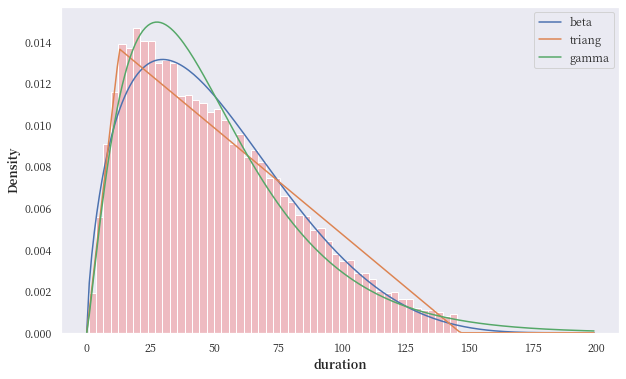

In [59]:
plot_fitted_distributions(
    cleaned_duration_low['duration'],
    ['beta', 'triang', 'gamma'],
    200,
    floc=0,  
)

In [60]:
(cleaned_duration_low['duration']*4/5).mean()

40.169259430120924

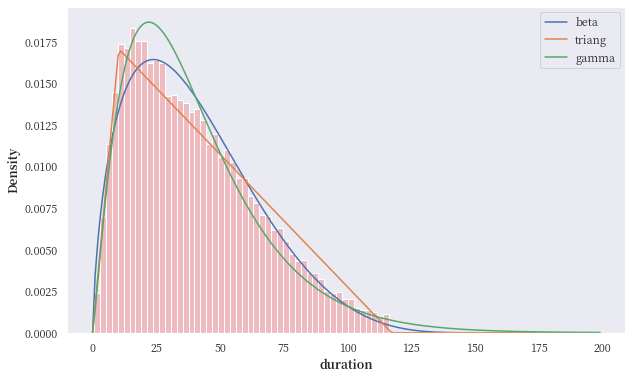

In [61]:
plot_fitted_distributions(
    cleaned_duration_low['duration']*4/5,
    ['beta', 'triang', 'gamma'],
    200,
    floc=0,  
)

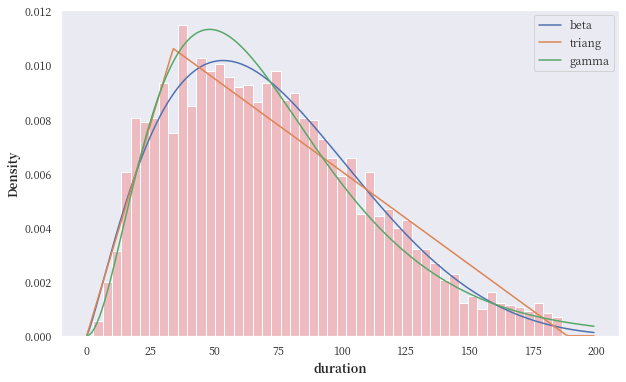

In [62]:
plot_fitted_distributions(
    cleaned_duration_med['duration'],
    ['beta', 'triang', 'gamma'],
    200,
    floc=0,  
)

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


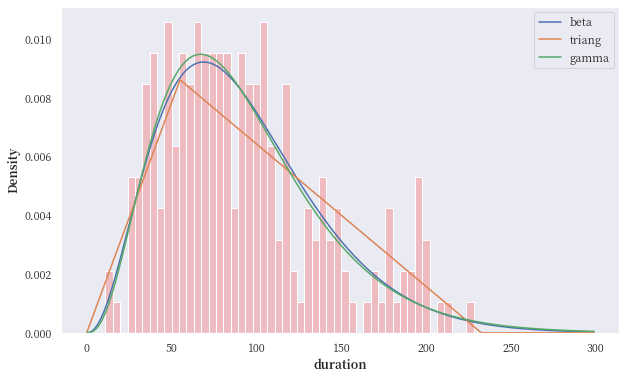

In [63]:
plot_fitted_distributions(
    cleaned_duration_high_crisis['duration'],
    ['beta', 'triang', 'gamma'],
    300,
    floc=0,  
)

In [64]:
def fit_distribution(y, dist_names, floc=None):
        
    # Create an empty list to stroe fitted distribution parameters
    parameters = []

    # Loop through the distributions ot get line fit and paraemters

    for dist_name in dist_names:
        # Set up distribution and store distribution paraemters
        dist = getattr(stats, dist_name)

        if floc is None:
            param = dist.fit(y)
        else:
            param = dist.fit(y, floc=floc)

        parameters.append(param)
        
    # Store distribution paraemters in a dataframe (this could also be saved)
    dist_parameters = pd.DataFrame()
    dist_parameters['Distribution'] = dist_names
    dist_parameters['Distribution parameters'] = parameters

    # Print parameter results
    print ('\nDistribution parameters:')
    print ('------------------------')

    for index, row in dist_parameters.iterrows():
        print ('\nDistribution:', row[0])
        print ('Parameters:', row[1] )

In [65]:
fit_distribution(
    cleaned_duration_low['duration'],
    ['beta', 'triang', 'gamma'], floc=0
)


Distribution parameters:
------------------------

Distribution: beta
Parameters: (1.6802706060428574, 4.669898835694633, 0, 190.34194306540343)

Distribution: triang
Parameters: (0.08734338167367639, 0, 146.62287055825718)

Distribution: gamma
Parameters: (2.215639799549132, 0, 22.66233631381278)


In [66]:
fit_distribution(
    cleaned_duration_low['duration']*4/5,
    ['beta', 'triang', 'gamma'], floc=0
)


Distribution parameters:
------------------------

Distribution: beta
Parameters: (1.680270656992354, 4.669898171331033, 0, 152.27353705896545)

Distribution: triang
Parameters: (0.08734338167367639, 0, 117.29829644660558)

Distribution: gamma
Parameters: (2.215639799549132, 0, 18.12986905105022)


In [67]:
fit_distribution(
    cleaned_duration_med['duration'],
    ['beta', 'triang', 'gamma'], 0
)


Distribution parameters:
------------------------

Distribution: beta
Parameters: (2.2181552733647263, 5.455822792292573, 0, 249.3022595240529)

Distribution: triang
Parameters: (0.1800951130999563, 0, 188.45894286969772)

Distribution: gamma
Parameters: (3.0305174795722847, 0, 23.742721587971012)


In [68]:
fit_distribution(
    cleaned_duration_high_crisis['duration'],
    ['beta', 'triang', 'gamma'], 0
)


Distribution parameters:
------------------------

Distribution: beta
Parameters: (3.3265952399595573, 27.04425338829236, 0, 840.2311330350152)

Distribution: triang
Parameters: (0.2366291449166537, 0, 232.51777947428798)

Distribution: gamma
Parameters: (3.7028050870101024, 0, 24.85117086471514)


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


## based on the stats and graphs, model chat duration with beta distribution

---

# 3.2. duration by typical/repeated/abusive users

## 3.2.1. Use natural log of usage count to separate the three groups

In [69]:
num_use = df_risklevels[(df_risklevels['tos_status']=='accepted') 
].groupby(['month', 'identifier'])[['_id']].count().reset_index()

In [70]:
num_use.rename(columns={'_id': 'total_usage_count'}, inplace=True)

# bin by natural log of usage count (7 categories - anything above middle category are abusers)

In [71]:
num_use['log_total_usage'] = np.log(num_use['total_usage_count'])#.round(1)

In [72]:
num_use

,month,identifier,total_usage_count,log_total_usage
0,1,1.36.120.47,3,1.098612
1,1,1.36.14.249,2,0.693147
2,1,1.36.153.2,2,0.693147
3,1,1.36.158.55,1,0.000000
4,1,1.36.168.204,2,0.693147
...,...,...,...,...
24705,12,oW9ep1evSQenWAlnFSXss7w7xoIQ,1,0.000000
24706,12,oW9ep1f1EAEqtkwNDOJhEcjUqwns,14,2.639057
24707,12,oW9ep1fElbC1l6DTkV-dpGypjLqU,5,1.609438
24708,12,oW9ep1fy7_6JU28Ue3wFGEJoaZrs,1,0.000000


<AxesSubplot:xlabel='log_total_usage', ylabel='Count'>

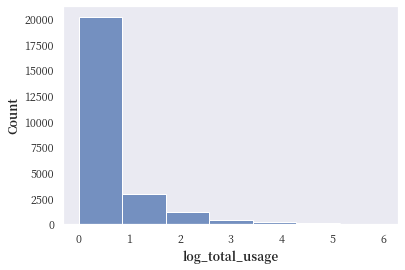

In [73]:
sns.histplot(data=num_use, x='log_total_usage', bins=7)


In [74]:
num_use['num_visit_bin']  = pd.cut(num_use['log_total_usage'], bins=7)

In [75]:
bin_labels = [ '1-2', '3-5', '6-13', '14-30', '31-72', '73-171', '172+']

In [76]:
num_use['num_visit_bin'] = num_use['num_visit_bin'].cat.rename_categories(bin_labels)

# set cutoff to >=14

In [77]:
tos_accepted_cases = df_risklevels[df_risklevels['tos_status']=='accepted'].merge(
    num_use, how='outer',
    on=['month', 'identifier'],
).copy()

In [78]:
# def generate_table(user_type, cutoff_repeated_user=14):# , cutoff_abusive_user=31):    
#     if user_type == 'typical':
#         subset = tos_accepted_cases[
#             (tos_accepted_cases['total_usage_count']<cutoff_repeated_user) &
#             (tos_accepted_cases['incoming']=='valid-case')
#         ].copy()
#     elif user_type == 'repeated':
# #         subset = tos_accepted_cases[
# #             (tos_accepted_cases['total_usage_count']>=cutoff_repeated_user) &
# #             (tos_accepted_cases['total_usage_count']<cutoff_abusive_user) &
# #             (tos_accepted_cases['incoming']=='valid-case')
# #         ].copy()
# #     elif user_type == 'abusive':
# #         subset = tos_accepted_cases[
# #             (tos_accepted_cases['total_usage_count']>=cutoff_abusive_user) &
# #             (tos_accepted_cases['incoming']=='valid-case')
# #         ].copy()
#         subset = tos_accepted_cases[
#             (tos_accepted_cases['total_usage_count']>=cutoff_repeated_user) &
#             (tos_accepted_cases['incoming']=='valid-case')
#         ].copy()
#     else:
#         return None
    
# #     return subset
#     df1 = subset.groupby('maxRiskLevel')['duration'].describe(percentiles=[.5,])
#     df1.sort_values(by=['count'], ascending=False, inplace=True)
#     df2 = subset[['duration']].describe(percentiles=[.5,]).rename(
#         columns={'duration':'All cases'}).T
#     return pd.concat([df1, df2], axis=0)

In [79]:
# generate_table('abusive')

# breakdown of repeated/non-repeated users

In [80]:
tos_accepted_cases['user_type'] = tos_accepted_cases['total_usage_count'].apply(
    lambda x: 'typical' if x<14 else 'repeated'#('repeated' if x in range(6, 31) else 'abusive')
)

In [81]:
tos_accepted_cases['incoming'].value_counts(normalize=True)

valid-case      0.564666
invalid-case    0.435334
Name: incoming, dtype: float64

In [82]:
tos_accepted_cases['incoming'].value_counts()

valid-case      35055
invalid-case    27026
Name: incoming, dtype: int64

In [83]:
tos_accepted_cases['user_type'].value_counts()

typical     44125
repeated    17956
Name: user_type, dtype: int64

In [84]:
tos_accepted_cases['user_type'].value_counts(normalize=True)

typical     0.710765
repeated    0.289235
Name: user_type, dtype: float64

In [85]:
data = tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='valid-case')
]

In [86]:
data['user_type'].value_counts(normalize=True)

typical     0.777321
repeated    0.222679
Name: user_type, dtype: float64

In [87]:
data['user_type'].value_counts()

typical     27249
repeated     7806
Name: user_type, dtype: int64

## plot histograms again

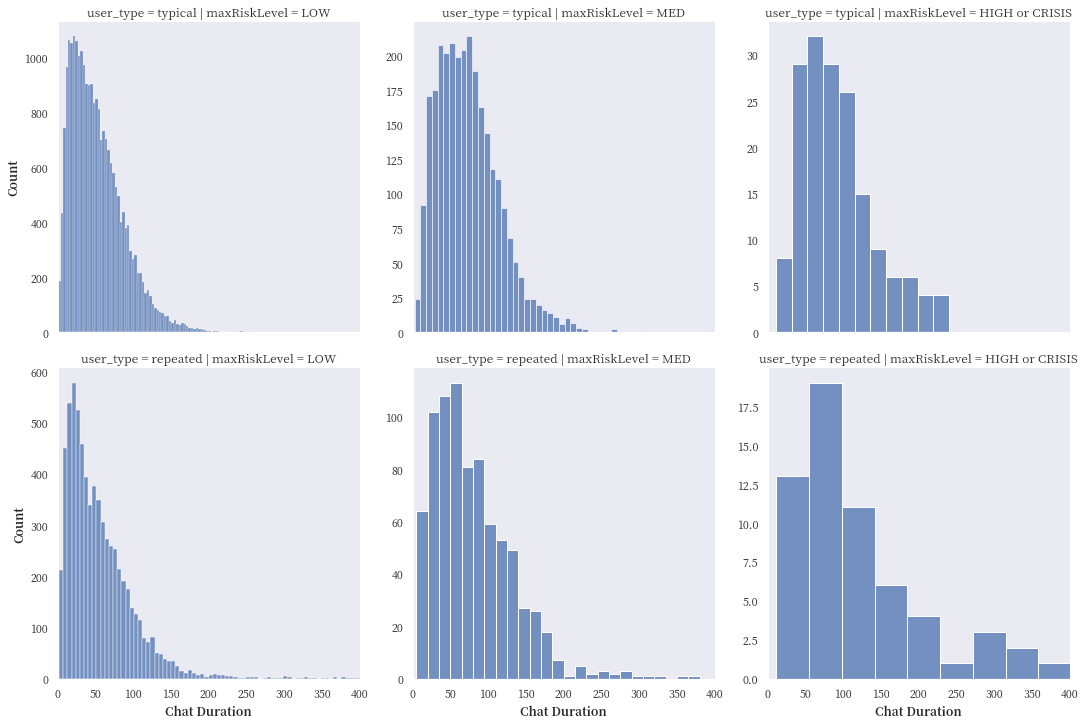

In [88]:
g = sns.FacetGrid(
    data,
    col='maxRiskLevel',
    row='user_type',
    height=5, aspect=1,
    sharey=False,
    sharex=True,
    xlim=(0, 400),
)
g.map_dataframe(sns.histplot, x='duration')
g.set_axis_labels('Chat Duration', 'Count')

# not much of a difference? - except HIGH or CRISIS cases?

In [89]:
tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='valid-case') &
    (tos_accepted_cases['user_type']=='typical')]['maxRiskLevel'].value_counts()

LOW               24266
MED                2815
HIGH or CRISIS      168
Name: maxRiskLevel, dtype: int64

In [90]:
tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='valid-case') &
    (tos_accepted_cases['user_type']=='typical')]['maxRiskLevel'].value_counts(normalize=True)

LOW               0.890528
MED               0.103307
HIGH or CRISIS    0.006165
Name: maxRiskLevel, dtype: float64

In [91]:
tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='valid-case') &
    (tos_accepted_cases['user_type']=='repeated')]['maxRiskLevel'].value_counts()

LOW               6932
MED                813
HIGH or CRISIS      61
Name: maxRiskLevel, dtype: int64

In [92]:
tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='valid-case') &
    (tos_accepted_cases['user_type']=='repeated')]['maxRiskLevel'].value_counts(normalize=True)

LOW               0.888035
MED               0.104151
HIGH or CRISIS    0.007815
Name: maxRiskLevel, dtype: float64

In [93]:
def separate_case(user_type, cutoff_repeated_user=14):   
    dataframes = []
    for risklevel in ['LOW', 'MED', 'HIGH or CRISIS']:
        df = remove_outliers(
            tos_accepted_cases[
                (tos_accepted_cases['incoming'] =='valid-case') &
                (tos_accepted_cases['maxRiskLevel']==risklevel) &
                (tos_accepted_cases['user_type']==user_type)
            ], 'duration'
        )

        dataframes.append(df)
    return pd.concat(dataframes)

In [94]:
typical_cases = separate_case('typical')

In [95]:
repeated_cases = separate_case('repeated')

In [96]:
generate_duration_stats(typical_cases)

,count,mean,std,min,50%,max
LOW,23780.0,50.073706,30.965849,0.768033,44.798617,142.900367
MED,2759.0,70.853129,36.795679,2.569267,67.201700,179.204183
HIGH or CRISIS,163.0,89.454594,44.184735,11.009767,82.305700,201.642183
All cases,26702.0,52.461149,32.465779,0.768033,46.981992,201.642183


In [97]:
generate_duration_stats(repeated_cases)

,count,mean,std,min,50%,max
LOW,6711.0,50.826649,34.185040,1.913367,43.287567,154.917867
MED,793.0,75.389691,45.048082,4.756717,66.989000,215.167267
HIGH or CRISIS,56.0,104.655854,64.140464,11.647283,90.288908,283.656133
All cases,7560.0,53.801904,36.821585,1.913367,46.114408,283.656133


In [98]:
for risk in ['LOW', 'MED', 'HIGH or CRISIS']:
    print(f'risklevel: {risk}')
    print(stats.mannwhitneyu(
        typical_cases[typical_cases['maxRiskLevel']==risk]['duration'],
        repeated_cases[repeated_cases['maxRiskLevel']==risk]['duration'],
    ) )
    print('\n')

risklevel: LOW
MannwhitneyuResult(statistic=78994013.0, pvalue=0.10456997926458927)


risklevel: MED
MannwhitneyuResult(statistic=1063811.0, pvalue=0.11822982524827791)


risklevel: HIGH or CRISIS
MannwhitneyuResult(statistic=4122.0, pvalue=0.14023808278395644)




In [99]:
    print(stats.mannwhitneyu(
        typical_cases['duration'],
        repeated_cases['duration'],
    ) )
    print('\n')

MannwhitneyuResult(statistic=100345563.5, pvalue=0.21931859298641704)




# mann whitney test on repeated/non-repeated cases: 
# no difference in `low` and `medium`, 
# only observable difference in `high or crisis` - but marginally

# breakdown of cases by risk (no outliers removed)

In [100]:
data['maxRiskLevel'].value_counts(normalize=True)

LOW               0.889973
MED               0.103495
HIGH or CRISIS    0.006533
Name: maxRiskLevel, dtype: float64

In [101]:
data['maxRiskLevel'].value_counts()

LOW               31198
MED                3628
HIGH or CRISIS      229
Name: maxRiskLevel, dtype: int64

In [102]:
total_max_risk_repeated = data[
    data['total_usage_count']>=14]['maxRiskLevel'].value_counts(normalize=True)
total_max_risk_typical = data[
    data['total_usage_count']<14]['maxRiskLevel'].value_counts(normalize=True)

In [103]:
total_max_risk_repeated
# total_max_risk_repeated.sum()

LOW               0.888035
MED               0.104151
HIGH or CRISIS    0.007815
Name: maxRiskLevel, dtype: float64

In [104]:
total_max_risk_typical
# total_max_risk_typical.sum()

LOW               0.890528
MED               0.103307
HIGH or CRISIS    0.006165
Name: maxRiskLevel, dtype: float64

# qq and distribution plots of repeated/non-repeated high/crisis cases

In [105]:
high_crisis_repeated_cases_duration = repeated_cases[
        (repeated_cases['maxRiskLevel']=='HIGH or CRISIS')
    ]['duration']

high_crisis_typical_cases_duration = typical_cases[
        (typical_cases['maxRiskLevel']=='HIGH or CRISIS')
    ]['duration']

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


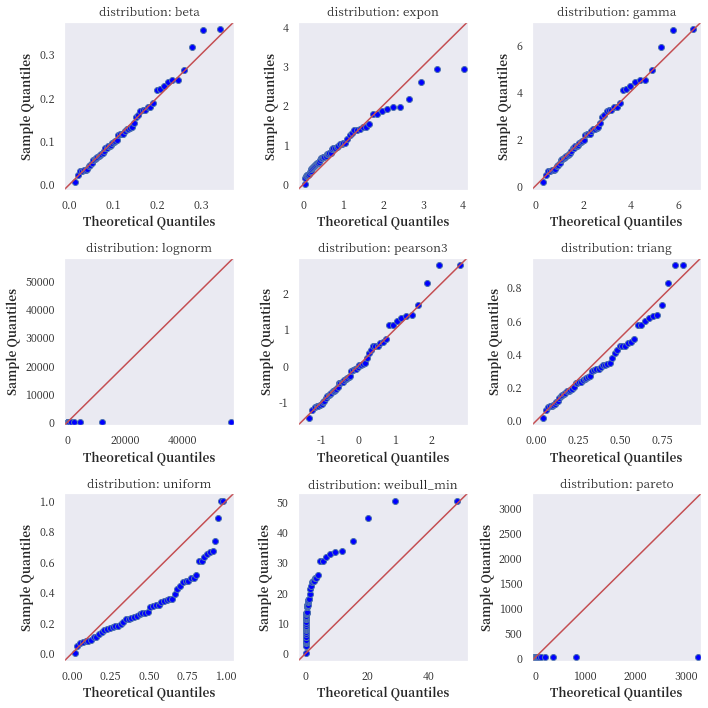

In [106]:
check_qq_plot(high_crisis_repeated_cases_duration)

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2429: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


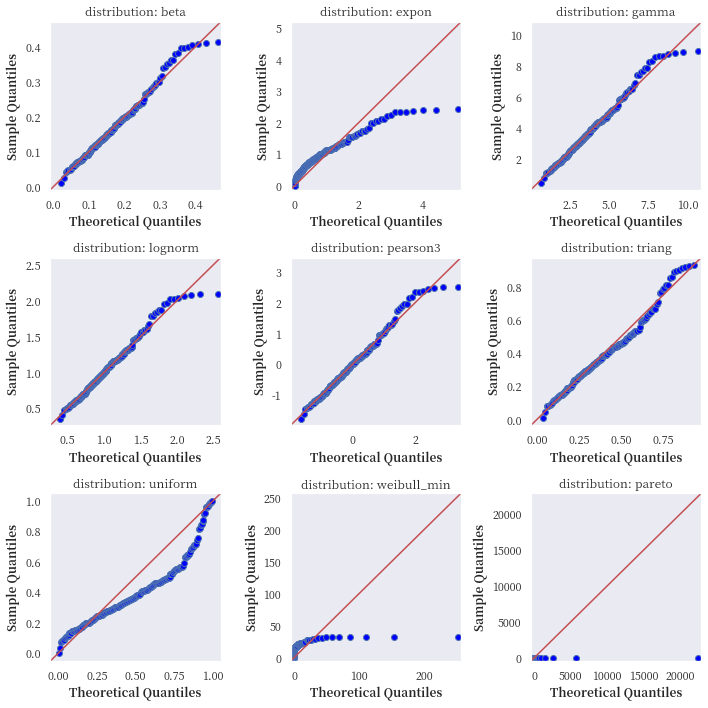

In [107]:
check_qq_plot(high_crisis_typical_cases_duration)

# fit distributions

<AxesSubplot:xlabel='duration', ylabel='Count'>

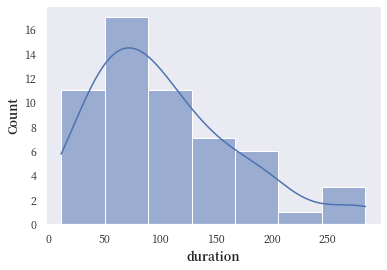

In [108]:
sns.histplot(high_crisis_repeated_cases_duration, kde=True)

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


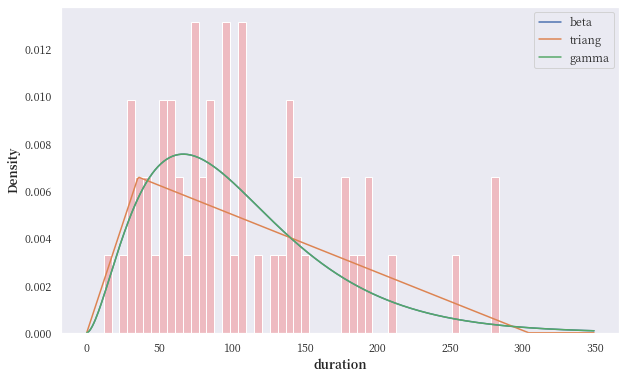

In [109]:
plot_fitted_distributions(
    high_crisis_repeated_cases_duration,
    ['beta', 'triang', 'gamma'],
    350,
    floc=0,  
)

In [110]:
fit_distribution(
    high_crisis_repeated_cases_duration,
    ['beta', 'triang', 'gamma'], floc=0
)


Distribution parameters:
------------------------

Distribution: beta
Parameters: (2.7361693673890146, 2636435.838963162, 0, 100845536.09100851)

Distribution: triang
Parameters: (0.11647980716378332, 0, 303.7994383653021)

Distribution: gamma
Parameters: (2.7364777993881004, 0, 38.244729628294635)


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


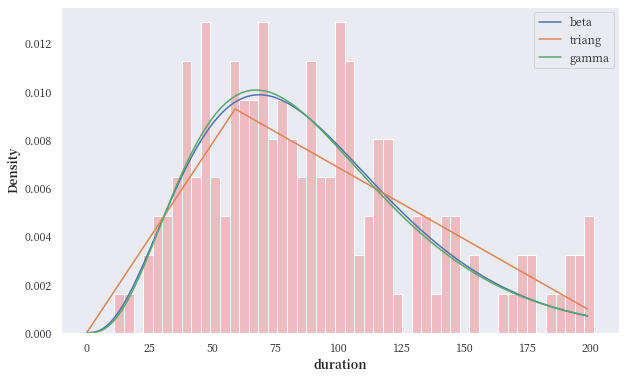

In [111]:
plot_fitted_distributions(
    high_crisis_typical_cases_duration,
    ['beta', 'triang', 'gamma'],
    200,
    floc=0,
)

In [112]:
fit_distribution(
    high_crisis_typical_cases_duration,
    ['beta', 'triang', 'gamma'], floc=0
)


Distribution parameters:
------------------------

Distribution: beta
Parameters: (3.7222294832681335, 39.73068165531829, 0, 1044.3489164490395)

Distribution: triang
Parameters: (0.2735071993100644, 0, 215.6598320412434)

Distribution: gamma
Parameters: (4.044547343564272, 0, 22.117331401651487)


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)


# 4. renege time/waiting time

In [113]:
df_waited = tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='valid-case')
].reset_index(drop=True).copy()

df_waited['wait_time'] = \
    df_waited['endQueueTime'] - df_waited['startDateTime']

df_waited['wait_time'] = df_waited['wait_time'].dt.total_seconds()/60

In [114]:
df_reneged = tos_accepted_cases[
    (tos_accepted_cases['incoming'] =='invalid-case')
].reset_index(drop=True).copy()

In [115]:
print(df_reneged.shape, df_waited.shape, tos_accepted_cases.shape)

(27026, 47) (35055, 48) (62081, 47)


In [116]:
try:
    # password authentication to login to MongoDB
    client = pymongo.MongoClient(
        host='localhost',
        port=27018,
        username='----USERNAME_REMOVED----',
        password='----PASSWORD_REMOVED----',
        authSource='OpenupDB',
        authMechanism='SCRAM-SHA-256',
    )

    # access Openup Database and authenticate
    db = client['OpenupDB']

    
    df_history = pd.DataFrame(
        list(db['data_management_history'].find({
            '$and': [
                { 'conversationId': {
                    '$in': df_reneged['uuid'].to_list() } },
                { '$or': [
                    { 'source.bHelpSeeker': True },
                    { 'nature': { '$in': [
                        'SYSTEM_HELPSEEKER_ENTER',
                        'SYSTEM_HELPSEEKER_LEAVES']
                    } }
                ] }    
            ] }
        ) ) )
    
#     df_history_waited = pd.DataFrame(
#         list(db['data_management_history'].find({ 
#             'conversationId': {
#                 '$in': df_waited['uuid'].to_list() },
#             'nature':'SYSTEM_JOINED',
#             'source.bHelpSeeker': False,
#             'message.metadata': { '$not': { '$eq':
#                 '${counsellor_display_name} 已加入'
#             } }
#         })
#     ) )
    
    client.close()
            

except:
    print('Cannot access OpenUp database.')
    if client:
        client.close()

In [117]:
# df_history_waited.sort_values(
#     by=['datetime'], ascending=True, inplace=True)
# df_history_waited.drop_duplicates(
#         subset=['conversationId'], keep='last', inplace=True)
# df_history_waited = df_history_waited.pivot(
#     index='conversationId', columns='nature', values='datetime')

In [118]:
df_history.sort_values(by=['datetime'], ascending=True, inplace=True)

In [119]:
last_msg = df_history[df_history['source'].apply(
    lambda x:x['bHelpSeeker'] == True)].copy()

In [120]:
last_msg.drop_duplicates(
        subset=['conversationId'], keep='last', inplace=True)

In [121]:
enter = df_history[df_history['nature']=='SYSTEM_HELPSEEKER_ENTER'].drop_duplicates(
        subset=['conversationId', 'nature'], keep='first').copy()

In [122]:
leave = df_history[df_history['nature']=='SYSTEM_HELPSEEKER_LEAVES'].drop_duplicates(
        subset=['conversationId', 'nature'], keep='last').copy()

In [123]:
df_history = pd.concat([enter, leave, last_msg])

In [124]:
df_history = df_history.pivot(index='conversationId', columns='nature', values='datetime')

In [125]:
# df_reneged.columns

In [126]:
# not_standard_columns = df_history.columns[~df_history.columns.isin(
#     ['SYSTEM_HELPSEEKER_ENTER', 'SYSTEM_HELPSEEKER_LEAVES'])]

In [127]:
# df_history = df_history.join(df_reneged[['uuid',
#     'endQueueTime', 'startDateTime']].set_index('uuid'))

In [128]:
# df_history['first_timestamp'] = df_history[not_standard_columns].min(axis=1)
# df_history['last_timestamp'] = df_history[not_standard_columns].max(axis=1)

In [129]:
# df_history['SYSTEM_HELPSEEKER_ENTER'].fillna(df_history['first_timestamp'], inplace=True)
# df_history['SYSTEM_HELPSEEKER_LEAVES'].fillna(df_history['last_timestamp'], inplace=True)

In [130]:
# df_history[df_history['SYSTEM_HELPSEEKER_ENTER'].isna() | 
# df_history['SYSTEM_HELPSEEKER_LEAVES'].isna()]

In [131]:
df_history['time_before_renege'] = (
    df_history['SYSTEM_HELPSEEKER_LEAVES'] - df_history['SYSTEM_HELPSEEKER_ENTER'])/ \
    np.timedelta64(1, 'm')

In [132]:
# df_history['time_before_renege'].isna().any()

In [133]:
df_history.max()

nature
BOUNCEBACK                  2020-02-18 11:49:23.246000
REGULAR_MESSAGE             2020-11-30 15:59:20.179000
REGULAR_USERPROFILE         2020-05-15 10:26:28.635000
SYSTEM_HELPSEEKER_ENTER     2020-11-30 15:58:29.757000
SYSTEM_HELPSEEKER_LEAVES    2020-11-30 22:41:59.682000
SYSTEM_ROOM_CREATED         2020-11-17 00:21:41.464000
time_before_renege                             15713.9
dtype: object

In [134]:
df_reneged = df_reneged.join(
    df_history['time_before_renege'], on='uuid')

In [135]:
df_reneged['wait_status'] = 'reneged'
df_waited['wait_status'] = 'served'

In [136]:
tos_accepted_cases = pd.concat([
    df_waited, df_reneged.rename(
    columns={'time_before_renege':'wait_time'})
]).reset_index(drop=True)

In [137]:
tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20)
][['wait_time']].describe().T

,count,mean,std,min,25%,50%,75%,max
wait_time,25938.0,4.891194,4.420759,1.0,1.649183,3.051942,6.648608,19.992883


In [138]:
tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20)
].groupby('wait_status')[['wait_time']].describe()

wait_time                                                    \
                count      mean       std       min       25%       50%   
wait_status                                                               
reneged       14475.0  5.061671  4.504108  1.000083  1.698483  3.195483   
served        11463.0  4.675924  4.303768  1.000000  1.584025  2.897800   

                                  
                  75%        max  
wait_status                       
reneged      6.976358  19.992883  
served       6.194525  19.985817

In [139]:
tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20)
].groupby(['wait_status', 'user_type'])[['wait_time']].describe()

wait_time                                          \
                          count      mean       std       min       25%   
wait_status user_type                                                     
reneged     repeated     4787.0  6.289486  4.999389  1.001867  2.041550   
            typical      9688.0  4.454987  4.104935  1.000083  1.614579   
served      repeated     3160.0  6.009999  4.963164  1.000800  1.977904   
            typical      8303.0  4.168194  3.906950  1.000000  1.498925   

                                                      
                            50%       75%        max  
wait_status user_type                                 
reneged     repeated   4.717567  9.203217  19.992883  
            typical    2.732542  5.839025  19.992833  
served      repeated   4.272358  8.765338  19.985817  
            typical    2.567767  5.229208  19.968783

In [140]:
from lifelines import KaplanMeierFitter, ExponentialFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines.utils import restricted_mean_survival_time
from lifelines.plotting import rmst_plot

# kmf = KaplanMeierFitter()
kmf = ExponentialFitter()

reneged 2.815335458483074          lambda_
lambda_  0.00114 4.061670504392387
served 2.5479561485266733           lambda_
lambda_  0.001179 3.6759236998819746


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          48.64 <0.005     38.24

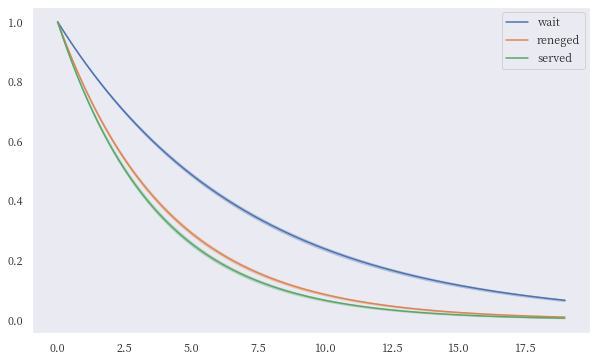

In [141]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

wait_times_df = tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20) #&
#     (tos_accepted_cases['month']==12)
]
T = wait_times_df['wait_time'] - 1
E = wait_times_df['wait_status'].replace({
    'reneged': True, # not picked up by agent is observed
    'served': False # picked up by agent is censored
})

kmf.fit(T, E, label='wait')
kmf.plot_survival_function(ax=ax)

# rmst = restricted_mean_survival_time(kmf, t=20)
# rmst_plot(kmf, t=20, ax=ax[1])

for i, (name, grouped_df) in enumerate(
    wait_times_df.groupby('wait_status') ):
    if name == 'served': # virtual waiting time V
        rep = {
            'reneged': False, # not picked up by agent is censored
            'served': True
        }
    else: # willing to wait/patience R
        rep = {
            'reneged': True,
            'served': False # picked up by agent is censored
        }

    kmf.fit(
        grouped_df['wait_time'] - 1,
        grouped_df['wait_status'].replace(rep), label=name)
    kmf.plot_survival_function(ax=ax)
    print(name, kmf.median_survival_time_, kmf.variance_matrix_, kmf.lambda_)
#     rmst_plot(kmf, t=20, ax=ax[i+2])
    
wt1 = wait_times_df[wait_times_df['wait_status']=='served']
wt2 = wait_times_df[wait_times_df['wait_status']=='reneged']
ev1 = wt1['wait_status'].replace({
            'reneged': False, # not picked up by agent is censored
            'served': True
        })
ev2 = wt2['wait_status'].replace({
            'reneged': True,
            'served': False # picked up by agent is censored
        })
results = logrank_test(
    wt1['wait_time'] - 1,
    wt2['wait_time'] - 1, 
    ev1, ev2, 
    alpha=.99
)

results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.00 1.00     -0.00

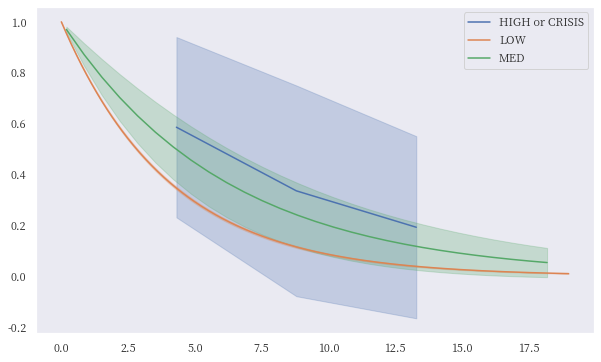

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

wait_times_df = tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20) &
    (tos_accepted_cases['wait_status']=='reneged')
]

for name, grouped_df in wait_times_df.groupby('maxRiskLevel'):
    rep = {
        'served': False,
        'reneged': True
    }

    kmf.fit(
        grouped_df['wait_time'] - 1,
        grouped_df['wait_status'].replace(rep), label=name)
    kmf.plot_survival_function(ax=ax)
    
results = multivariate_logrank_test(
    wait_times_df['wait_time'] - 1,
    wait_times_df['maxRiskLevel'], 
    wait_times_df['wait_status'].replace({
        'reneged': False, # not picked up by agent is censored
        'served': True
    }), 
    alpha=.99
)

results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           3.21 0.20      2.32

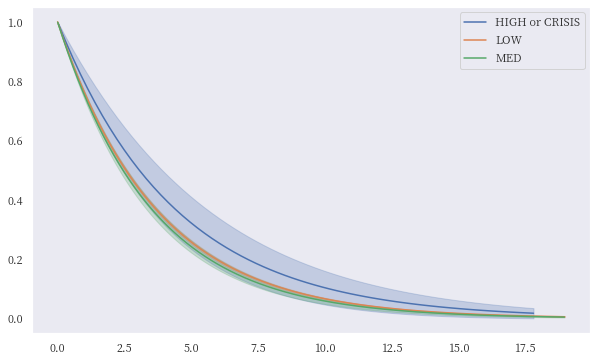

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

wait_times_df = tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20) &
    (tos_accepted_cases['wait_status']=='served')
]

for name, grouped_df in wait_times_df.groupby('maxRiskLevel'):
    rep = {
        'reneged': False, # not picked up by agent is censored
        'served': True
    }

    kmf.fit(
        grouped_df['wait_time'] - 1,
        grouped_df['wait_status'].replace(rep), label=name)
    kmf.plot_survival_function(ax=ax)
    
results = multivariate_logrank_test(
    wait_times_df['wait_time'] - 1,
    wait_times_df['maxRiskLevel'], 
    wait_times_df['wait_status'].replace({
        'reneged': False, # not picked up by agent is censored
        'served': True
    }), 
    alpha=.99
)

results.print_summary()

# virtual waiting time

repeated 3.4726664492998456           lambda_
lambda_  0.007943 5.009998665066372
typical 2.196024973456832           lambda_
lambda_  0.001209 3.168194338874489


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         354.88 <0.005    260.56

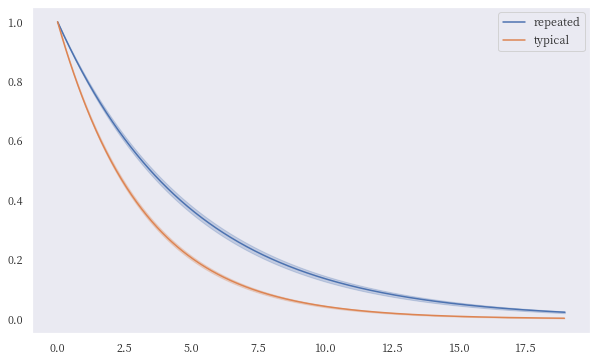

In [144]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

wait_times_df = tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20) &
    (tos_accepted_cases['wait_status']=='served')
]

for name, grouped_df in wait_times_df.groupby('user_type'):
    rep = {
        'reneged': False, # not picked up by agent is censored
        'served': True
    }

    kmf.fit(
        grouped_df['wait_time'] - 1,
        grouped_df['wait_status'].replace(rep), label=name)
    kmf.plot_survival_function(ax=ax)
    
    print(name, kmf.median_survival_time_, kmf.variance_matrix_,
         kmf.lambda_)
    
results = multivariate_logrank_test(
    wait_times_df['wait_time'] - 1,
    wait_times_df['user_type'], 
    wait_times_df['wait_status'].replace({
        'reneged': False, # not picked up by agent is censored
        'served': True
    }), 
    alpha=.99
)

results.print_summary()

# actual patience

repeated 3.6663924329197743           lambda_
lambda_  0.005845 5.28948618092618
typical 2.394814223214726           lambda_
lambda_  0.001232 3.4549866036822405


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         459.23 <0.005    336.01

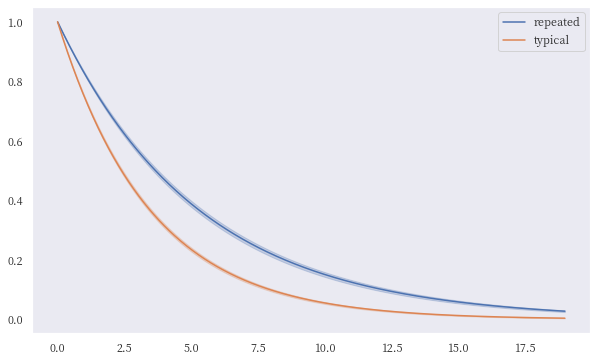

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

wait_times_df = tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20) &
    (tos_accepted_cases['wait_status']=='reneged')
]

for name, grouped_df in wait_times_df.groupby('user_type'):
    rep = {
        'reneged': True,
        'served': False
    }

    kmf.fit(
        grouped_df['wait_time'] - 1,
        grouped_df['wait_status'].replace(rep), label=name)
    kmf.plot_survival_function(ax=ax)
    print(name, kmf.median_survival_time_, kmf.variance_matrix_,
         kmf.lambda_)
    
results = multivariate_logrank_test(
    wait_times_df['wait_time'] - 1,
    wait_times_df['user_type'], 
    wait_times_df['wait_status'].replace({
        'reneged': True,
        'served': False
    }), 
    alpha=.99
)

results.print_summary()

('repeated', 'HIGH or CRISIS')
('repeated', 'LOW')
('repeated', 'MED')
('typical', 'HIGH or CRISIS')
('typical', 'LOW')
('typical', 'MED')


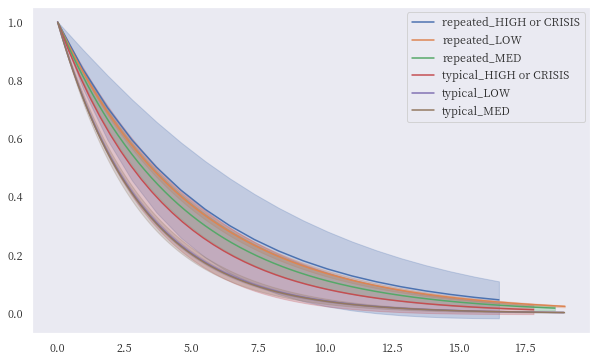

In [146]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )

wait_times_df = tos_accepted_cases[
    (tos_accepted_cases['wait_time']>=1) &
    (tos_accepted_cases['wait_time']<20) &
    (tos_accepted_cases['wait_status']=='served')
]

idx = 0
for name, grouped_df in wait_times_df.groupby(
    ['user_type', 'maxRiskLevel']):
    print(name)
    rep = {
        'reneged': False, # not picked up by agent is censored
        'served': True
    }

    kmf.fit(
        grouped_df['wait_time'] - 1,
        grouped_df['wait_status'].replace(rep), label=f'{name[0]}_{name[1]}')
    kmf.plot_survival_function(ax=ax)

In [147]:
wt1 = wait_times_df[wait_times_df['maxRiskLevel']=='LOW']


results = multivariate_logrank_test(
    wt1['wait_time'] - 1,
    wt1['user_type'], 
    wt1['wait_status'].replace({
        'reneged': False, # not picked up by agent is censored
        'served': True
    }), 
    alpha=.99
)

results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
         335.28 <0.005    246.38

In [148]:
wt1 = wait_times_df[wait_times_df['maxRiskLevel']=='MED']


results = multivariate_logrank_test(
    wt1['wait_time'] - 1,
    wt1['user_type'], 
    wt1['wait_status'].replace({
        'reneged': False, # not picked up by agent is censored
        'served': True
    }), 
    alpha=.99
)

results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          20.99 <0.005     17.72

In [149]:
wt1 = wait_times_df[wait_times_df['maxRiskLevel']=='HIGH or CRISIS']


results = multivariate_logrank_test(
    wt1['wait_time'] - 1,
    wt1['user_type'], 
    wt1['wait_status'].replace({
        'reneged': False, # not picked up by agent is censored
        'served': True
    }), 
    alpha=.99
)

results.print_summary()

<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = multivariate_logrank_test

---
 test_statistic    p  -log2(p)
           0.35 0.56      0.85

In [150]:
def plot_tos_status_breakdown(by):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8) )
    palette = 'Set2'

    sns.kdeplot(
        data=df_risklevels, x=by, hue='tos_status',
        multiple='fill',
        ax=ax1,
        palette=palette
    )
    # overwrite existing label
    ax1.set_ylabel('Probability')
    
    if by == 'hour':
        ax1.set_xlim(0, 24)
    
    elif by == 'startDateTime_floor':
        ax1.set_xlim(datetime.datetime(2020, 1, 1), datetime.datetime(2020, 11, 1, 23) )

    sns.histplot(
        data=df_risklevels, x=by, hue='tos_status',
        discrete=True,
        multiple='dodge', 
        ax=ax2,
        palette=palette
    )
    

[(-1.0, 30.0)]

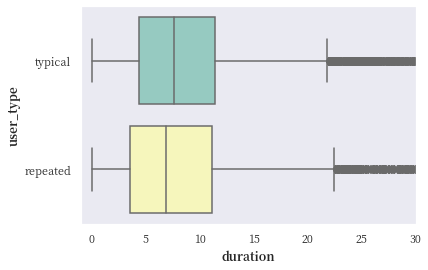

In [151]:
g = sns.boxplot(
    data=tos_accepted_cases[
        (tos_accepted_cases['incoming']=='invalid-case')],
    y='user_type', x='duration',
    palette='Set3'
)

g.set(xlim=(-1, 30))

# set the cutoff to 7.5 minutes (median)

In [152]:
tos_accepted_cases[
        (tos_accepted_cases['incoming']=='invalid-case')]['duration'].describe()

count    27024.000000
mean        11.539167
std        205.875132
min          0.041117
25%          4.107096
50%          7.355058
75%         11.314312
max      19521.020550
Name: duration, dtype: float64

[(0.0, 24.0)]

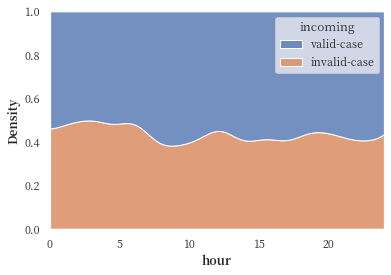

In [153]:
g = sns.kdeplot(
    data=tos_accepted_cases,
    x='hour',
    hue='incoming',
    multiple='fill', 
)
g.set(xlim=(0, 24))

[(0.0, 24.0)]

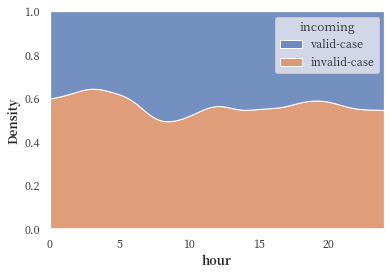

In [154]:
g = sns.kdeplot(
    data=tos_accepted_cases[
        tos_accepted_cases['user_type']=='repeated'],
    x='hour',
    hue='incoming',
    multiple='fill', 
)
g.set(xlim=(0, 24))

[(0.0, 24.0)]

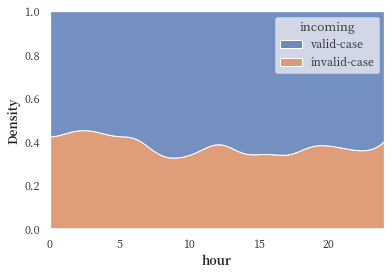

In [155]:
g = sns.kdeplot(
    data=tos_accepted_cases[
        tos_accepted_cases['user_type']=='typical'],
    x='hour',
    hue='incoming',
    multiple='fill', 
)
g.set(xlim=(0, 24))

In [156]:
tos_accepted_cases[
    tos_accepted_cases['user_type']=='repeated'].groupby(
    ['incoming'])[['_id']].count()/ tos_accepted_cases[
    tos_accepted_cases['user_type']=='repeated'].groupby(
    ['incoming'])[['_id']].count().sum()

,_id
incoming,
invalid-case,0.565271
valid-case,0.434729


In [157]:
valid_state = tos_accepted_cases.groupby(
    ['incoming', 'hour'])[['_id']].count().reset_index().pivot(
    index='hour', columns='incoming', values='_id')

In [158]:
valid_state['all'] = valid_state.sum(axis=1)

In [159]:
valid_state_ratio = valid_state.divide(valid_state['all'], axis=0)

In [160]:
valid_state_ratio.drop(columns=['all'])

incoming,invalid-case,valid-case
hour,,
0,0.458876,0.541124
1,0.491233,0.508767
2,0.490249,0.509751
3,0.523786,0.476214
4,0.446212,0.553788
5,0.473469,0.526531
6,0.517310,0.482690
7,0.459016,0.540984
8,0.357752,0.642248


---

# 5. generate interarrivals from data

# explore cases from July 31, 2020 (this will be removed later)

In [161]:
time_gte = start.replace(tzinfo=None)
# time_gte = start

In [162]:
# df_inv = df_risklevels
df_inv = tos_accepted_cases

In [163]:
# df_inv = df_inv[
#     df_inv['startDateTime']>=time_gte].copy()

In [164]:
# df_inv = df_inv[df_inv['user_type']=='typical'].copy()

In [165]:
df_inv.sort_values(by=['startDateTime'], inplace=True)

In [166]:
df_inv.reset_index(drop=True, inplace=True)

# remove openup/csrp ip/test-drill cases

In [167]:
# df_inv = df_inv[~df_inv['identifier'].str.contains('210.3.169.22') &
#     ~df_inv['identifier'].str.contains('147.8.19[3-5]')].copy()

In [168]:
# df_inv = df_inv[~(df_inv['helpseeker_alias'].notna() & 
#         df_inv['helpseeker_alias'].str.contains('[Tt]est(ing){0,1}|[Dd]rill') )].copy()

# remove identifiers arriving within 2 hour window

In [169]:
# df_inv['startDateTime_floor2'] = df_inv['startDateTime_floor'].dt.floor('6h')

In [170]:
df_inv.drop_duplicates(
    subset=['startDateTime_floor', 'identifier'],
    # subset=['startDateTime', 'identifier'],
    keep='first', inplace=True)

In [171]:
df_inv

,_id,pingpongCount,startDateTime,status,uuid,endQueueTime,endDateTime,summary,helpseeker,identifier,...,day_of_week,day_int,date,startDateTime_floor,total_usage_count,log_total_usage,num_visit_bin,user_type,wait_time,wait_status
0,606d6d9c6726694af30d7f08,1,2019-12-01 00:00:11.633,FINISHED,912b4b73-8495-46f4-8e3c-f23b6ee8d921,2019-12-01 00:09:04.378,2019-12-01 00:21:18.341,個案直接離線,"{'bHelpSeeker': True, 'ipAddress': '219.78.40....",219.78.40.193,...,Sunday,6,2019-12-01,2019-12-01 00:00:00,1,0.000000,1-2,typical,26.243733,reneged
1,606d6d9c6726694af30d7f07,27,2019-12-01 00:00:18.851,FINISHED,87d4b44c-c2fa-461c-b652-ced9846a698f,2019-12-01 00:00:34.786,2019-12-01 00:36:25.743,"miffy\r\nchat summary: 喜歡教會一個人, 因此有忐忑不安. 舒緩後離線","{'bHelpSeeker': True, 'lastMsgTime': 2019-11-3...",oW9ep1eAxMrLAzCIMVFeP2-_xork,...,Sunday,6,2019-12-01,2019-12-01 00:00:00,7,1.945910,6-13,typical,0.265583,served
2,606d6d9c6726694af30d7f06,7,2019-12-01 00:01:07.478,FINISHED,0c0f236e-3e84-4949-83e0-8ee24f078fae,2019-12-01 01:38:35.275,2019-12-01 02:51:04.009,個案直接離線,"{'bHelpSeeker': True, 'ipAddress': '223.18.45....",223.18.45.27,...,Sunday,6,2019-12-01,2019-12-01 00:00:00,361,5.888878,172+,repeated,97.463283,served
4,606d6d9c6726694af30d7f03,49,2019-12-01 00:14:22.420,FINISHED,c6ded3cd-aa84-41f1-a3b1-7c1777e5354c,2019-12-01 00:15:23.239,2019-12-01 01:40:55.687,"Jacob, 20/M, 單親家庭成長, 有一個姐姐, 小時間缺乏照顧, 經常逃學, 到中學...","{'bHelpSeeker': True, 'ipAddress': '58.177.52....",58.177.52.221,...,Sunday,6,2019-12-01,2019-12-01 00:00:00,1,0.000000,1-2,typical,1.013650,served
5,606d6d9c6726694af30d7f02,56,2019-12-01 00:15:07.009,FINISHED,bd0fa4c9-379a-4854-b888-a875fd1d189c,2019-12-01 00:16:15.895,2019-12-01 01:29:39.074,19/M、未知職業、人際關係問題、沒有潛在危機\r\n\r\n個案背景： \r\n服務使用者...,"{'bHelpSeeker': True, 'ipAddress': '61.93.0.18...",61.93.0.188,...,Sunday,6,2019-12-01,2019-12-01 00:00:00,24,3.178054,14-30,repeated,1.148100,served
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62075,606d6d3c6726694af30c3ab5,29,2020-11-30 23:22:46.903,FINISHED,8980d862-9698-46cc-a28c-506b1d993612,2020-11-30 23:25:43.755,2020-12-01 00:42:41.743,"Chris\r\n因害怕父母的責備而很多事不想做及不敢做, 令他感覺自己浪費人生.","{'bHelpSeeker': True, 'ipAddress': '116.49.162...",116.49.162.46,...,Monday,0,2020-11-30,2020-11-30 22:00:00,1,0.000000,1-2,typical,2.947533,served
62076,606d6d3c6726694af30c3ab4,1,2020-11-30 23:27:10.298,FINISHED,5a151573-5fdc-4c42-a2cb-f85c29f9f4f1,2020-11-30 23:58:44.197,2020-12-01 00:08:57.026,個案直接離線,"{'bHelpSeeker': True, 'lastMsgTime': 2020-11-3...",4111004202275567,...,Monday,0,2020-11-30,2020-11-30 22:00:00,7,1.945910,6-13,typical,NaN,reneged
62077,606d6d3c6726694af30c3ab1,1,2020-11-30 23:40:49.684,FINISHED,74f92d23-4d8e-46c8-90ed-4601bf27fd83,2020-11-30 23:43:08.427,2020-11-30 23:58:17.282,個案直接離線,"{'bHelpSeeker': True, 'ipAddress': '124.244.85...",124.244.85.40,...,Monday,0,2020-11-30,2020-11-30 22:00:00,9,2.197225,6-13,typical,3.130633,reneged
62078,606d6d3c6726694af30c3ab0,25,2020-11-30 23:44:52.536,FINISHED_NEED_FOLLOWUP,b29ab852-73f4-4ce0-a3cf-003f2dfee5e4,2020-11-30 23:51:51.239,2020-12-01 00:42:50.568,NaN,"{'bHelpSeeker': True, 'ipAddress': '123.202.15...",123.202.151.254,...,Monday,0,2020-11-30,2020-11-30 22:00:00,1,0.000000,1-2,typical,6.978383,served


In [172]:
# df_inv = df_inv[
#     (df_inv['identifier'] != df_inv['identifier'].shift(1)) | 
#     df_inv['identifier'].shift(1).isna()
# ].copy()

In [173]:
df_inv.reset_index(drop=True, inplace=True)

In [174]:
df_inv['startDateTime_shift'] = df_inv['startDateTime'].shift(periods=1)
# df_inv['startDateTime_shift'] = df_inv.groupby(['date', 'hour'])['startDateTime'].shift(periods=1)

In [175]:
df_inv['startDateTime_shift'].fillna(time_gte, inplace=True)
# df_inv['startDateTime_shift'].fillna(df_inv['startDateTime'].dt.floor('H'), inplace=True)

In [176]:
df_inv['interarrival_time'] = \
    df_inv['startDateTime'] - df_inv['startDateTime_shift']

In [177]:
# convert interarrival time to minutes
df_inv['interarrival_time'] = \
    df_inv['interarrival_time'] / np.timedelta64(1, 'm')

# # so that routines in last cells will not break
# df_inv['interarrival_time'] = df_inv['interarrival_time'].dt.total_seconds()

In [178]:
df_inv.columns

Index(['_id', 'pingpongCount', 'startDateTime', 'status', 'uuid',
       'endQueueTime', 'endDateTime', 'summary', 'helpseeker', 'identifier',
       'firstRiskLevel', 'maxRiskLevel', 'exitRiskLevel', 'numAudits',
       'duration', 'chatbotTriaged', 'repeated_user', 'community_referral',
       'connectednesscare_sent', 'helpseeker_alias', 'counsellor',
       'tos_status', 'gender', 'age', 'issues', 'counsellor_firstRiskLevel',
       'chatbot_audit_count', 'counsellor_audit_count', 'referral',
       'safetyplan', 'chatbot_firstRiskLevel', 'superceded_chatbot_RiskLevel',
       'incoming', 'hour', 'month', 'week', 'year', 'startdate', 'enddate',
       'day_of_week', 'day_int', 'date', 'startDateTime_floor',
       'total_usage_count', 'log_total_usage', 'num_visit_bin', 'user_type',
       'wait_time', 'wait_status', 'startDateTime_shift', 'interarrival_time'],
      dtype='object')

## 5.1. exploring interarrivals

In [179]:
def plot_histogram(by):
    g = sns.FacetGrid(
        df_inv,
        col=by,
        height=5, aspect=1,
        sharey=True,
        sharex=True,
        col_wrap=4,
        xlim=(0, 50),
    )
    g.map(sns.histplot, 'interarrival_time' )
    g.set_axis_labels('Interarrival time (minutes)', 'Count')

### by day of week - note: interarrivals appear to be exponential
## looks like we can model interarrivals as a Poisson process

In [180]:
df_inv.groupby(['day_of_week'])['interarrival_time'].describe()

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,6554.0,11.415427,15.136420,0.001400,2.582021,6.718642,14.354204,303.022733
Monday,7029.0,10.860114,13.789884,0.000417,2.533700,6.380000,13.808433,226.446517
Saturday,6500.0,11.532047,15.057665,0.001067,2.569208,6.556317,14.582575,192.342017
Sunday,6992.0,10.903844,14.757680,0.002750,2.471504,6.182375,13.715075,213.363533
Thursday,6683.0,11.212137,14.707229,0.000133,2.422758,6.370333,14.256642,201.400000
Tuesday,6591.0,11.352349,15.055919,0.000350,2.582725,6.533733,14.454792,263.323100
Wednesday,6659.0,11.253038,15.023554,0.000033,2.649317,6.614833,14.180433,322.566817


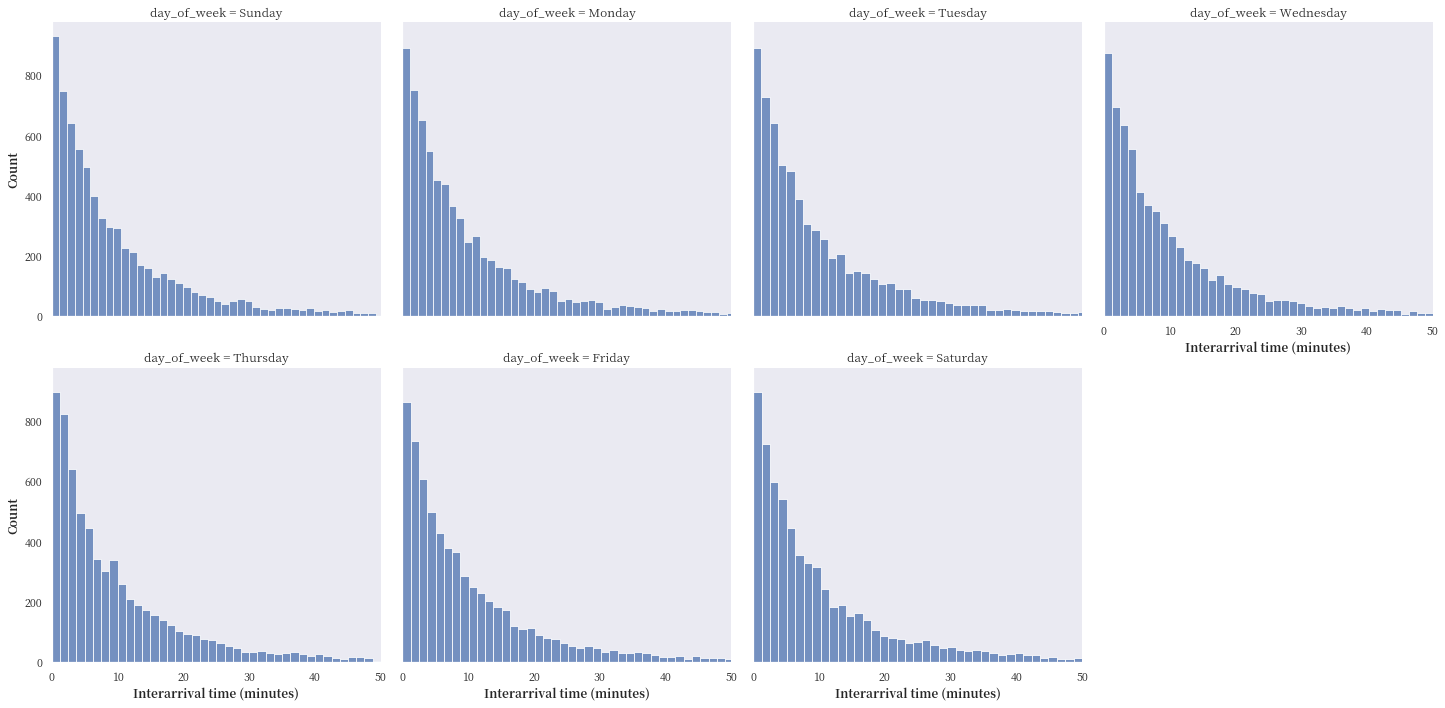

In [181]:
plot_histogram('day_of_week')

## interarrivals are similar by day of week, hence seasonal effect is negligible (also see kde below)

### by hour

In [182]:
df_inv.groupby(['hour'])['interarrival_time'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,3224.0,6.791744,7.092084,0.003100,1.802304,4.600692,9.374446,52.147000
1,2325.0,8.931294,8.955933,0.008967,2.434233,6.141383,12.277100,56.722650
2,2037.0,10.407965,10.688258,0.001983,3.006400,7.020483,14.320850,82.369700
3,1295.0,15.294508,14.951126,0.011500,4.316175,10.340583,21.559067,89.593650
4,1079.0,18.446495,19.470595,0.006550,4.453900,11.608333,25.234250,122.107450
5,687.0,27.552541,24.963243,0.002217,7.931183,20.524950,40.710442,148.715167
6,748.0,28.700881,29.675717,0.022217,7.431883,18.215767,39.648308,184.445200
7,740.0,30.288396,33.689947,0.027867,7.155183,18.913100,42.857687,201.400000
8,1144.0,22.113476,27.873785,0.000350,5.052804,12.834033,26.705421,226.446517


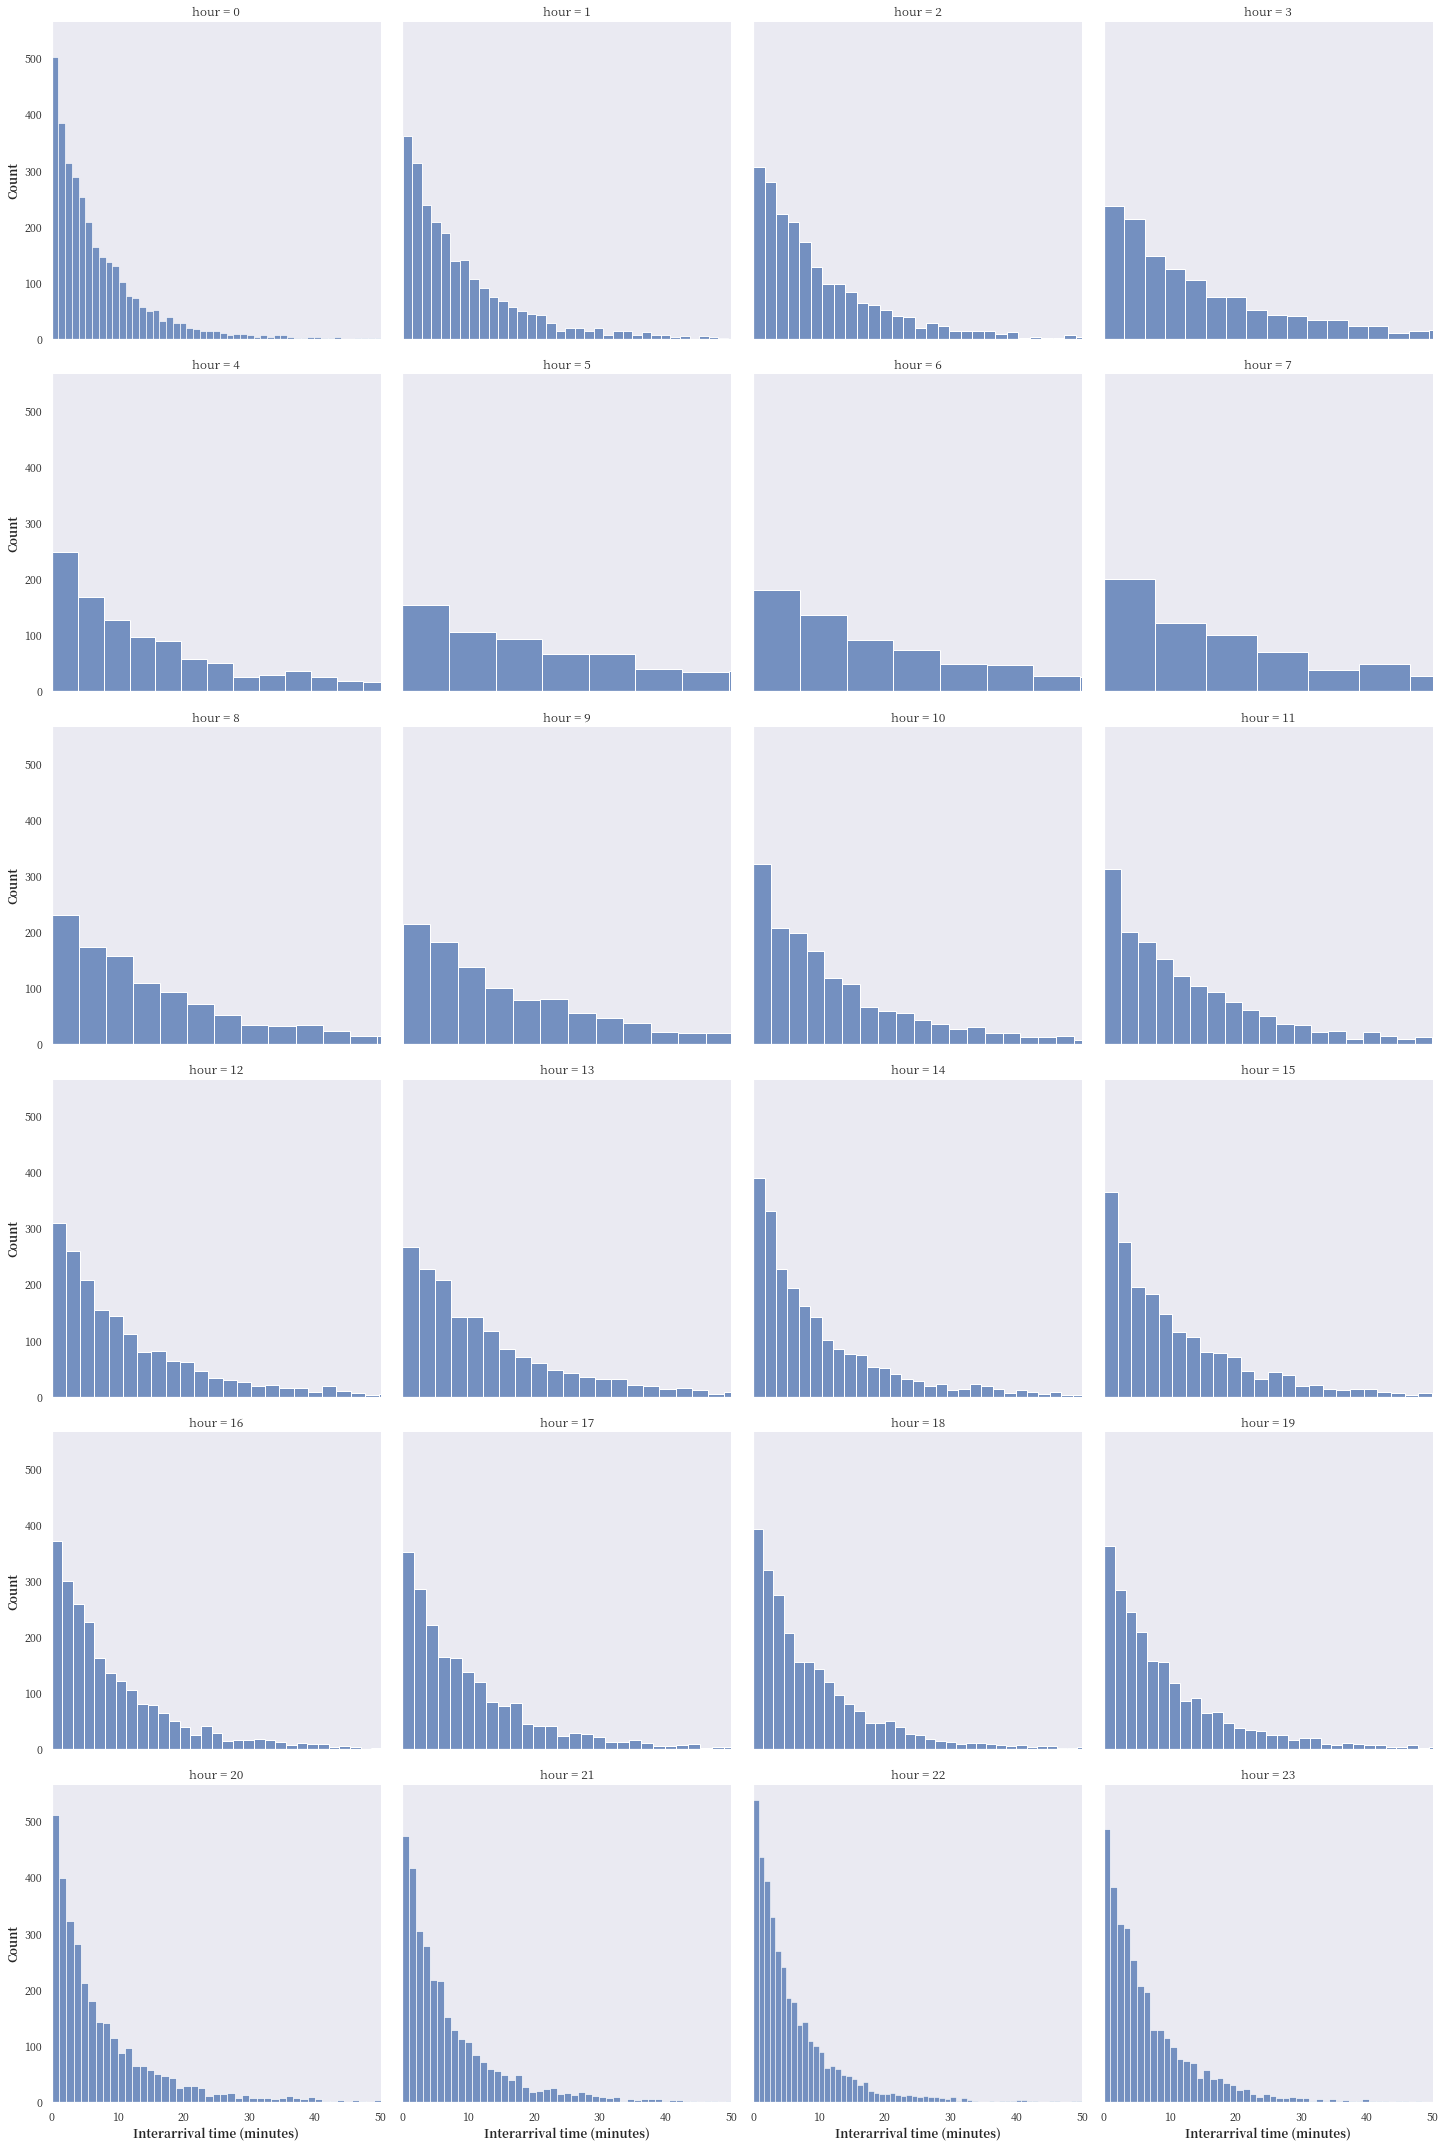

In [183]:
plot_histogram('hour')

## overlapped day of week KDE are almost the same, but not the same by hour (arrivals are hour dependent)- time series model can focus on hourly cases only

Text(0.5, 0, 'Interarrival Time (minutes)')

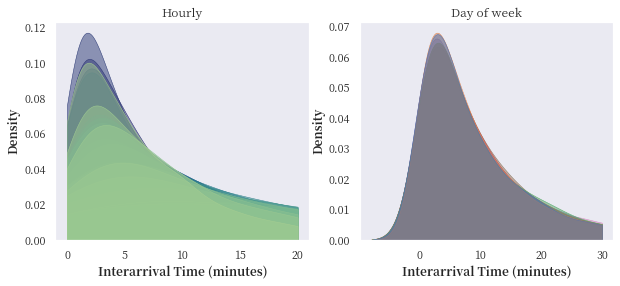

In [184]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4) )

sns.kdeplot(data=df_inv,
    x='interarrival_time',
    hue='hour',
    palette='crest',
    clip=(0, 20),
    legend=False,
    common_norm=False,
    fill=True, linewidth=0.5,
    alpha=.5,
    ax=ax1
)

sns.kdeplot(data=df_inv,
    x='interarrival_time',
    hue='day_of_week',
#     palette='crest',
    clip=(-10, 30),
    legend=False,
    common_norm=False,
    fill=True, linewidth=0.5,
    alpha=.5,
    ax=ax2
)

ax1.set_title('Hourly')
ax1.set_xlabel('Interarrival Time (minutes)')

ax2.set_title('Day of week')
ax2.set_xlabel('Interarrival Time (minutes)')

In [185]:
# interarrivals = df_inv[['startDateTime', 'interarrival_time', 'user_type']].copy().set_index('startDateTime')
interarrivals = df_inv[['startDateTime', 'interarrival_time']].copy().set_index('startDateTime')

In [186]:
# interarrival_stats = df_risklevels['interarrival_time'].describe()
# outliers = 1.5 * (interarrival_stats['75%'] - interarrival_stats['25%'])

In [187]:
# s = df_risklevels[df_risklevels['interarrival_time']<outliers].copy()

In [188]:
# interarrivals = s[['startDateTime', 'interarrival_time']].copy().set_index('startDateTime')

In [189]:
df_inv.columns

Index(['_id', 'pingpongCount', 'startDateTime', 'status', 'uuid',
       'endQueueTime', 'endDateTime', 'summary', 'helpseeker', 'identifier',
       'firstRiskLevel', 'maxRiskLevel', 'exitRiskLevel', 'numAudits',
       'duration', 'chatbotTriaged', 'repeated_user', 'community_referral',
       'connectednesscare_sent', 'helpseeker_alias', 'counsellor',
       'tos_status', 'gender', 'age', 'issues', 'counsellor_firstRiskLevel',
       'chatbot_audit_count', 'counsellor_audit_count', 'referral',
       'safetyplan', 'chatbot_firstRiskLevel', 'superceded_chatbot_RiskLevel',
       'incoming', 'hour', 'month', 'week', 'year', 'startdate', 'enddate',
       'day_of_week', 'day_int', 'date', 'startDateTime_floor',
       'total_usage_count', 'log_total_usage', 'num_visit_bin', 'user_type',
       'wait_time', 'wait_status', 'startDateTime_shift', 'interarrival_time'],
      dtype='object')

# ACF plots to check seasonality

In [190]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


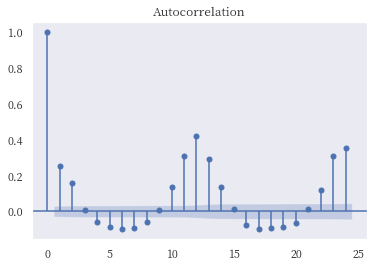

In [191]:
plot_acf(interarrivals.resample('2h').mean().fillna(0)['interarrival_time'], lags=24);

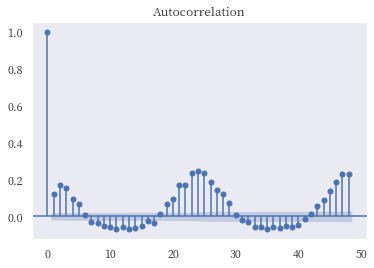

In [192]:
plot_acf(interarrivals.resample('h').mean().fillna(0)['interarrival_time'], lags=48);

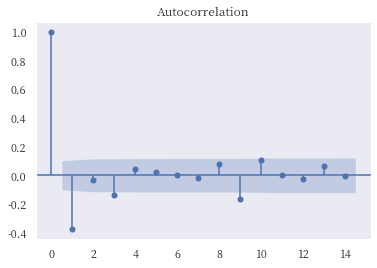

In [193]:
s1 = interarrivals.resample('30min').mean().fillna(0)['interarrival_time']
s2 = s1.shift(48)

plot_acf(
    (s1-s2)[48:].resample('d').mean(), 
    lags=14);

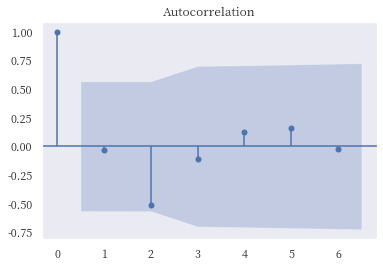

In [194]:
plot_acf((s1-s2)[48:].resample('M').mean(), lags=6);

<AxesSubplot:xlabel='startDateTime'>

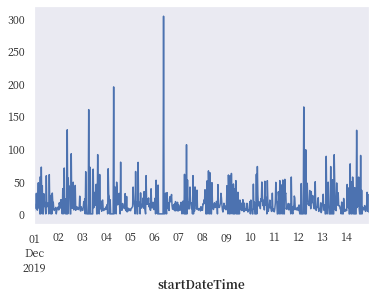

In [195]:
s1[:48*14].plot()

# Approximate with a State-Space Model

In [196]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [197]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# interpolate data

In [198]:
interp_interarrival = interarrivals.resample('2h').mean().interpolate(
    method='pchip')
# interp_interarrival = interarrivals.resample('2h').mean().interpolate(
#     method='piecewise_polynomial')
# interp_interarrival = interarrivals.resample('2h').mean().fillna(0)

In [199]:
interarrivals['hour'] = interarrivals.index.hour

In [200]:
interarrivals

,interarrival_time,hour
startDateTime,,
2019-12-01 00:00:11.633,0.193883,0
2019-12-01 00:00:18.851,0.120300,0
2019-12-01 00:01:07.478,0.810450,0
2019-12-01 00:14:22.420,13.249033,0
2019-12-01 00:15:07.009,0.743150,0
...,...,...
2020-11-30 23:22:46.903,8.553767,23
2020-11-30 23:27:10.298,4.389917,23
2020-11-30 23:40:49.684,13.656433,23


# average interarrival time by hour and user type

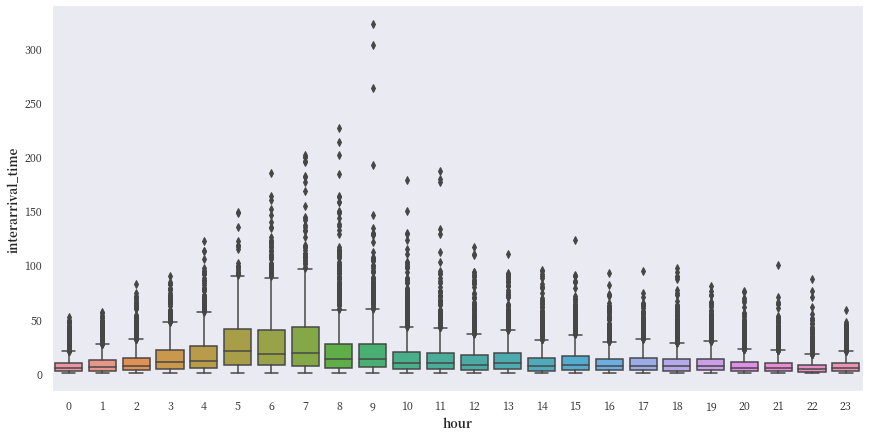

In [201]:
g = sns.catplot(
    x='hour', y='interarrival_time',
#     col='user_type',
    kind='box',
    data=interarrivals, height=6, aspect=2
)

# g.set(ylim=(0, 80))

In [202]:
# for hour in range(24):
#     test_result = stats.mannwhitneyu(
#         interarrivals[
#             (interarrivals['user_type']=='typical') &
#             (interarrivals['hour']==hour)
#         ]['interarrival_time'],
#         interarrivals[(interarrivals['user_type']=='repeated') &
#             (interarrivals['hour']==hour)
#         ]['interarrival_time'],
#     )
#     if test_result.pvalue < .05:
#         print(f'hour: {hour}')
#         print(test_result)
#         print('\n')

In [203]:
# g = sns.JointGrid(
#     data=interarrivals,
#     x='hour',
#     y='interarrival_time',
#     hue='user_type',
#     height=8
# )

# g.plot_joint(sns.scatterplot, alpha=.4)
# g.plot_marginals(sns.kdeplot, common_norm=False, common_grid=True)

# interarrivals different at 3am, 6am, 10pm, 3pm, 8pm, 9pm, 10pm
# other times the same

In [204]:
# df_risklevels['startDateTime_floor'] = df_risklevels['startDateTime'].dt.floor('2h')

In [205]:
# interarrival_stats = df_risklevels['interarrival_time'].describe()

In [206]:
# outliers = 1.5 * (interarrival_stats['75%'] - interarrival_stats['25%'])

In [207]:
# # interp_interarrival = df_risklevels[df_risklevels['interarrival_time']<outliers].groupby(
# interp_interarrival = df_risklevels.groupby(

# #     [ 'day_int', 'hour',]
# # #     ['hour']
#     ['startDateTime_floor']
# )[['interarrival_time']].mean()

In [208]:
interp_interarrival

,interarrival_time
startDateTime,
2019-12-01 00:00:00,8.444297
2019-12-01 02:00:00,14.693257
2019-12-01 04:00:00,19.032117
2019-12-01 06:00:00,48.339600
2019-12-01 08:00:00,34.015517
...,...
2020-11-30 14:00:00,9.283825
2020-11-30 16:00:00,7.791410
2020-11-30 18:00:00,12.860039


In [209]:
interp_interarrival.reset_index(inplace=True)

<AxesSubplot:>

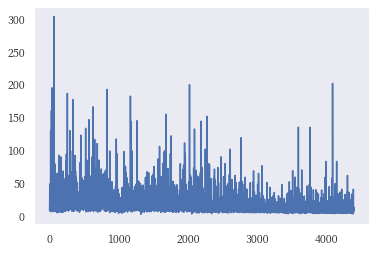

In [210]:
interp_interarrival['interarrival_time'].plot()

In [211]:
interp_interarrival.columns = ['ds', 'y']

In [212]:
interp_interarrival

,ds,y
0,2019-12-01 00:00:00,8.444297
1,2019-12-01 02:00:00,14.693257
2,2019-12-01 04:00:00,19.032117
3,2019-12-01 06:00:00,48.339600
4,2019-12-01 08:00:00,34.015517
...,...,...
4387,2020-11-30 14:00:00,9.283825
4388,2020-11-30 16:00:00,7.791410
4389,2020-11-30 18:00:00,12.860039
4390,2020-11-30 20:00:00,9.006030


In [213]:
interarrivals_output = interp_interarrival[
    interp_interarrival['ds']>=datetime.datetime(2020, 7, 1)].copy().reset_index(drop=True)

In [214]:
interarrivals_output.to_csv('interarrivals_day_of_week_hour/Jul2020_to_Nov2020/interarrivals_day_of_week_hour.csv')

# normalize data

In [215]:
# interp_interarrival_rep['transformed'], lamb_rep = boxcox(interp_interarrival_rep['y'])
# interp_interarrival_typ['transformed'], lamb_typ = boxcox(interp_interarrival_typ['y']) 
interp_interarrival['transformed'], lamb = boxcox(interp_interarrival['y']) 

In [216]:
lamb

-0.3863895801556619

# daily seasonal

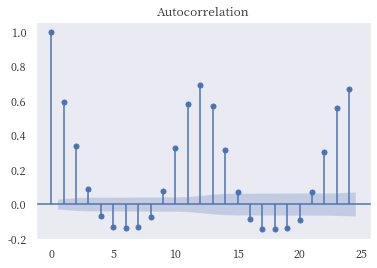

In [217]:
plot_acf(interp_interarrival['transformed'], lags=24);

## looks like AR1 from the seasonal differenced data

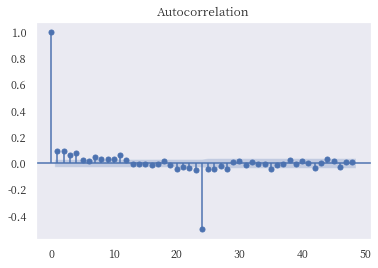

In [218]:
plot_acf((interp_interarrival['transformed']-interp_interarrival['transformed'].shift(24))[24:], lags=48);

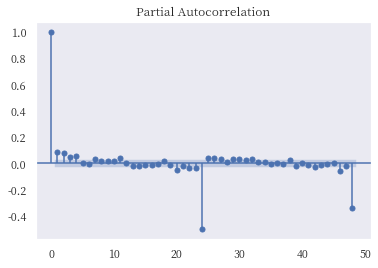

In [219]:
plot_pacf((interp_interarrival['transformed']-interp_interarrival['transformed'].shift(24))[24:], lags=48);

# back transformation function

In [220]:
def backtransformed_mean(transformed_mu, variance, lambda_):
    if lambda_ == 0:
        y_expected = np.exp(transformed_mu) * (1 + variance/2)
    else:
        y_expected = np.power(
            lambda_*transformed_mu + 1, 1/lambda_) *(
            1 + ( variance * (1-lambda_)/(
                2*(lambda_*transformed_mu + 1)**2 )
        ))
    return y_expected

# arrival rate time series 

In [221]:
interp_interarrival.set_index('ds', inplace=True)

In [222]:
interp_interarrival.index.freq = '2h'
# interp_interarrival_typ.index.freq = '2h'
# interp_interarrival_rep.index.freq = '2h'

In [223]:
s = interp_interarrival
slamb = lamb

In [224]:
s

,y,transformed
ds,,
2019-12-01 00:00:00,8.444297,1.453155
2019-12-01 02:00:00,14.693257,1.671815
2019-12-01 04:00:00,19.032117,1.758986
2019-12-01 06:00:00,48.339600,2.009729
2019-12-01 08:00:00,34.015517,1.925615
...,...,...
2020-11-30 14:00:00,9.283825,1.493967
2020-11-30 16:00:00,7.791410,1.417313
2020-11-30 18:00:00,12.860039,1.623400


# add campaign dates

In [225]:
# from workalendar.asia import HongKong

In [226]:
# cal = HongKong()

In [227]:
# cal.holidays(2020)

In [228]:
# holidays = [(datetime.date(2019, 12, 25), 'christmas_ny'),
#  (datetime.date(2019, 12, 26), 'christmas_ny'),
#  (datetime.date(2020, 1, 1),   'christmas_ny'),
#  (datetime.date(2020, 1, 25), 'CNY'),
#  (datetime.date(2020, 1, 26), 'CNY'),
#  (datetime.date(2020, 1, 27), 'CNY'),
#  (datetime.date(2020, 1, 28), 'CNY'),
#  (datetime.date(2020, 4, 4), 'chingming'),
#  (datetime.date(2020, 4, 10), 'easter'),
#  (datetime.date(2020, 4, 11), 'easter'),
#  (datetime.date(2020, 4, 13), 'easter'),
#  (datetime.date(2020, 4, 30), 'easter'),
#  (datetime.date(2020, 5, 1), 'other'),
#  (datetime.date(2020, 6, 25), 'other'),
#  (datetime.date(2020, 7, 1), 'other'),
#  (datetime.date(2020, 10, 1), 'other'),
#  (datetime.date(2020, 10, 2), 'other'),
#  (datetime.date(2020, 10, 25), 'other'),
#  (datetime.date(2020, 10, 26), 'other')
# ]

In [229]:
# for h in holidays:
#     s.loc[
#         (s.index.date == h[0] ),
#         f'holiday_{h[1]}'] = True
#     s[f'holiday_{h[1]}'].fillna(False ,inplace=True)

In [230]:
# s.loc[
#     (s.index.date == datetime.date(2020, 7, 22) ),
#     'dse'] = True
# s['dse'].fillna(False ,inplace=True)

In [231]:
# s.loc[
#     (s.index.date == datetime.date(2020, 9, 3) )|
#     (s.index.date == datetime.date(2020, 9, 25) ) |
#     (s.index.date == datetime.date(2020, 10, 12) ),
#     'fb_promotion'] = True
# s['fb_promotion'].fillna(False ,inplace=True)

In [232]:
for i in [
    [datetime.datetime(2020, 2, 21), 
     datetime.datetime(2020, 2, 24)], # HKU Psychiatry Promotion
    [datetime.datetime(2020, 3, 19), 
     datetime.datetime(2020, 3, 23)], # Manner Video
    [datetime.datetime(2020, 5, 19), 
     datetime.datetime(2020, 5, 22)], # Pomato Video
]:
    s.loc[
        (s.index >= i[0] ) &
        (s.index < i[1] ),
        'promotion'] = True


In [233]:
s['promotion'].fillna(False ,inplace=True)

In [234]:
s.loc[
    (s.index >= datetime.datetime(2020, 11, 30) ),
    'libel'] = True
s['libel'].fillna(False ,inplace=True)

In [235]:
s

,y,transformed,promotion,libel
ds,,,,
2019-12-01 00:00:00,8.444297,1.453155,False,False
2019-12-01 02:00:00,14.693257,1.671815,False,False
2019-12-01 04:00:00,19.032117,1.758986,False,False
2019-12-01 06:00:00,48.339600,2.009729,False,False
2019-12-01 08:00:00,34.015517,1.925615,False,False
...,...,...,...,...
2020-11-30 14:00:00,9.283825,1.493967,False,True
2020-11-30 16:00:00,7.791410,1.417313,False,True
2020-11-30 18:00:00,12.860039,1.623400,False,True


In [236]:
s['day'] = s.index.weekday.isin(range(1, 6))

In [237]:
s

,y,transformed,promotion,libel,day
ds,,,,,
2019-12-01 00:00:00,8.444297,1.453155,False,False,False
2019-12-01 02:00:00,14.693257,1.671815,False,False,False
2019-12-01 04:00:00,19.032117,1.758986,False,False,False
2019-12-01 06:00:00,48.339600,2.009729,False,False,False
2019-12-01 08:00:00,34.015517,1.925615,False,False,False
...,...,...,...,...,...
2020-11-30 14:00:00,9.283825,1.493967,False,True,False
2020-11-30 16:00:00,7.791410,1.417313,False,True,False
2020-11-30 18:00:00,12.860039,1.623400,False,True,False


# select subset to fit

In [238]:

from_date = datetime.datetime(2020, 4, 1)
upto_date = datetime.datetime(2020, 8, 1)

fragment = s[
    (s.index>=from_date ) &
#     (s.index<datetime.datetime(2020, 12, 1) )
    (s.index<upto_date )
].copy()

fragment['transformed'], slamb = boxcox(fragment['y']) 

In [239]:
slamb

-0.4927996964114881

<AxesSubplot:>

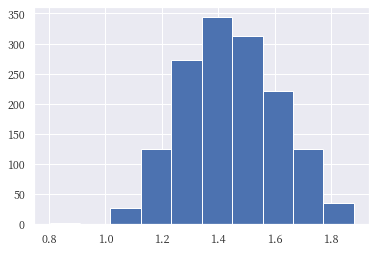

In [240]:
pd.Series(fragment['transformed']).hist()

In [241]:
model = UnobservedComponents(
    fragment['transformed'],
#     level='fixed intercept',
#     level='dconstant',
    level='local level',
    freq_seasonal=[
        {'period': 12,'harmonics': 6},
#         {'period': 12*7,'harmonics': 2}
    ],
    exog=fragment[['promotion',
#                   'day'
                  ]],
    stochastic_freq_seasonal=[False, ],
#     stochastic_freq_seasonal=[False, False],
    autoregressive=1,
    loglikelihood_burn=12,
    mle_regression=True
)

In [242]:
res_f = model.fit(disp=False, maxiter=1000)

In [243]:
res_f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Unobserved Components Results                           
==================================================================================
Dep. Variable:                transformed   No. Observations:                 1464
Model:                        local level   Log Likelihood                1213.923
                   + freq_seasonal(12(6))   AIC                          -2417.845
                                  + AR(1)   BIC                          -2391.442
Date:                    Fri, 12 Nov 2021   HQIC                         -2407.993
Time:                            13:48:49                                         
Sample:                        04-01-2020                                         
                             - 07-31-2020                                         
Covariance Type:                      opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0088      0.001      6.897      0.000       0.006       0.011
sigma2.level       4.28e-06   2.61e-06      1.642      0.101   -8.29e-07    9.39e-06
sigma2.ar            0.0013      0.001      0.996      0.319      -0.001       0.004
ar.L1                0.4811      0.263      1.826      0.068      -0.035       0.997
beta.promotion      -0.0972      0.018     -5.445      0.000      -0.132      -0.062
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                43.67
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.15
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1722: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1722: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


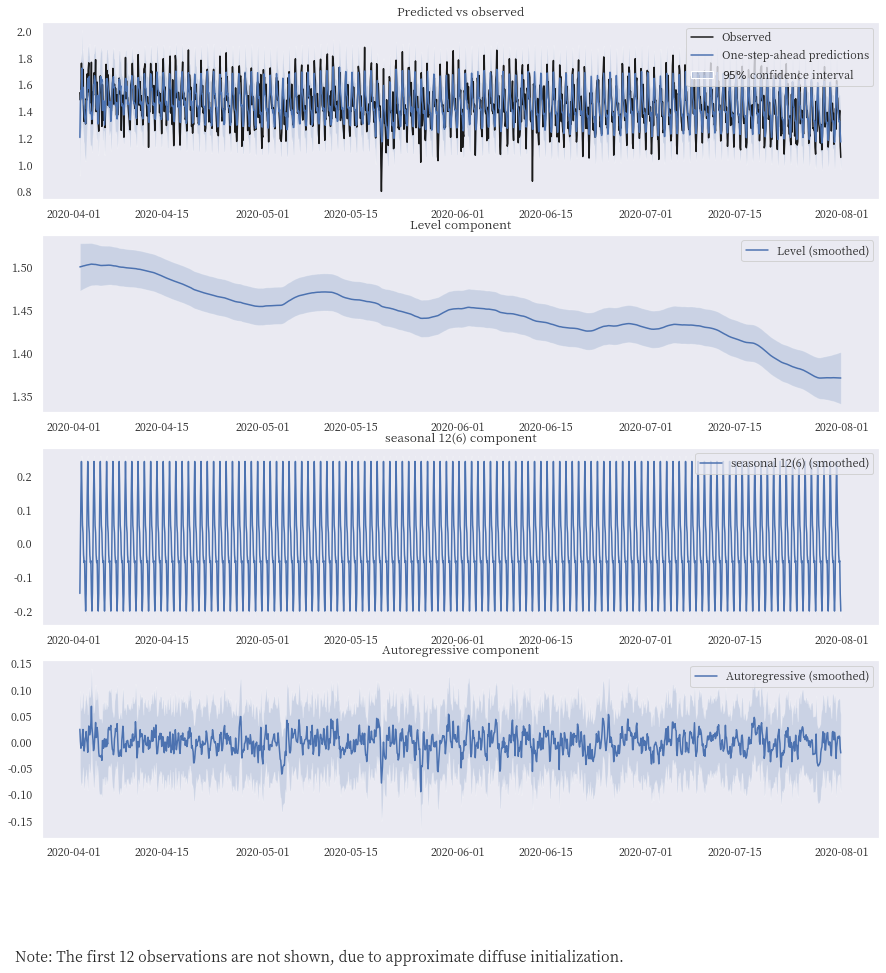

In [244]:
res_f.plot_components(figsize=(15, 15))
plt.show()

In [245]:
# up_to_datetime = datetime.datetime(2020, 12, 1) - \
#     datetime.timedelta(hours=1)
up_to_datetime = upto_date + datetime.timedelta(days=30, hours=0)
    
fcast = res_f.get_forecast(
    steps=up_to_datetime,
    exog=[False for _ in range(361)]
)

In [246]:
fcast.predicted_mean

2020-08-01 00:00:00    1.213799
2020-08-01 02:00:00    1.372137
2020-08-01 04:00:00    1.511000
2020-08-01 06:00:00    1.614623
2020-08-01 08:00:00    1.528236
                         ...   
2020-08-30 16:00:00    1.315408
2020-08-30 18:00:00    1.320830
2020-08-30 20:00:00    1.223572
2020-08-30 22:00:00    1.171231
2020-08-31 00:00:00    1.223600
Freq: 2H, Name: predicted_mean, Length: 361, dtype: float64

In [247]:
true = s.reindex(fcast.predicted_mean.index)['y']

In [248]:
fcast_ib = backtransformed_mean(
    fcast.predicted_mean, fcast.var_pred_mean, slamb)
error = true - fcast_ib

mean_absolute_error = error.abs().mean()
percentage_error = error/true *100
mean_abs_percentage_error = percentage_error.abs().mean()

root_mean_square_error = np.sqrt((error**2).mean())
mean_absolute_error, root_mean_square_error, mean_abs_percentage_error

(3.737487695515104, 6.6553847792772425, 27.97799010927809)

In [249]:
# pd.concat([
#     true.rename('true'),
#     fcast_ib.rename('forecast'),
#     error.rename('error')], axis=1)

In [250]:
fcast_ib.rename('forecast')

2020-08-01 00:00:00     6.673991
2020-08-01 02:00:00    10.612207
2020-08-01 04:00:00    17.929620
2020-08-01 06:00:00    29.945985
2020-08-01 08:00:00    19.356003
                         ...    
2020-08-30 16:00:00     8.951797
2020-08-30 18:00:00     9.101234
2020-08-30 20:00:00     6.898482
2020-08-30 22:00:00     6.031741
2020-08-31 00:00:00     6.899337
Freq: 2H, Name: forecast, Length: 361, dtype: float64

In [251]:
exog_may = [False for _ in range(30*12)]

In [252]:
for i in range(216, 264):
    exog_may[i]= True

# make forecast

In [253]:
fc = res_f.get_forecast(steps=30*12,
#     exog=exog_may#
    exog=[False for _ in range(30*12)]
)

In [254]:
print(fc.summary_frame())

transformed              mean   mean_se  mean_ci_lower  mean_ci_upper
2020-08-01 00:00:00  1.213799  0.103331       1.011274       1.416324
2020-08-01 02:00:00  1.372137  0.103777       1.168737       1.575536
2020-08-01 04:00:00  1.511000  0.103931       1.307299       1.714702
2020-08-01 06:00:00  1.614623  0.103999       1.410788       1.818457
2020-08-01 08:00:00  1.528236  0.104038       1.324326       1.732146
...                       ...       ...            ...            ...
2020-08-30 14:00:00  1.338447  0.111033       1.120826       1.556068
2020-08-30 16:00:00  1.315408  0.111051       1.097753       1.533064
2020-08-30 18:00:00  1.320830  0.111069       1.103139       1.538520
2020-08-30 20:00:00  1.223572  0.111086       1.005847       1.441298
2020-08-30 22:00:00  1.171231  0.111104       0.953471       1.388991

[360 rows x 4 columns]


In [255]:
s

,y,transformed,promotion,libel,day
ds,,,,,
2019-12-01 00:00:00,8.444297,1.453155,False,False,False
2019-12-01 02:00:00,14.693257,1.671815,False,False,False
2019-12-01 04:00:00,19.032117,1.758986,False,False,False
2019-12-01 06:00:00,48.339600,2.009729,False,False,False
2019-12-01 08:00:00,34.015517,1.925615,False,False,False
...,...,...,...,...,...
2020-11-30 14:00:00,9.283825,1.493967,False,True,False
2020-11-30 16:00:00,7.791410,1.417313,False,True,False
2020-11-30 18:00:00,12.860039,1.623400,False,True,False


# boxcox arrival rate

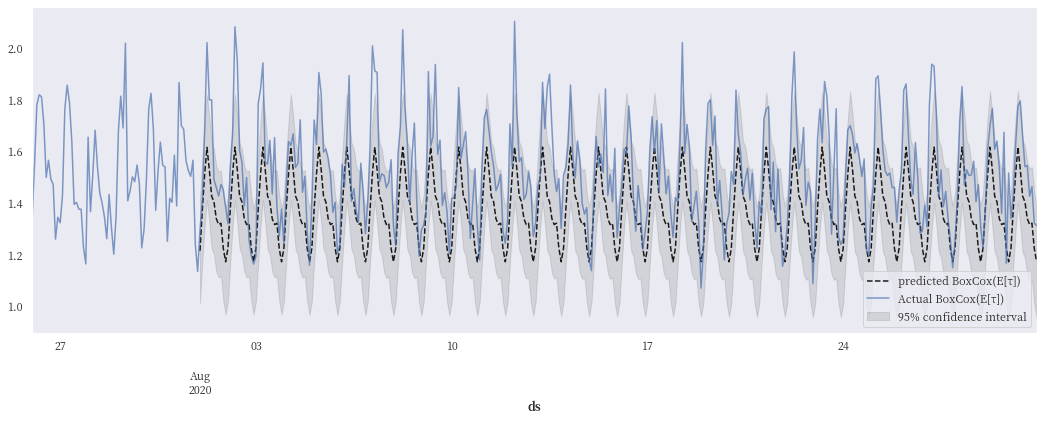

In [256]:
from scipy.stats import norm

fig, ax = plt.subplots(1, 1, figsize=(18, 6) )

forecast = fc.summary_frame()
forecast['mean'].plot(ax=ax, style='k--')
ax.fill_between(
    forecast.index,
    forecast['mean_ci_lower'],
    forecast['mean_ci_upper'], color='black', alpha=0.1,
    label='95% confidence interval'
);

s[(s.index<up_to_datetime) & (
    s.index>=up_to_datetime - \
    datetime.timedelta(days=36))
 ]['transformed'].plot(ax=ax, alpha=.7)

legend = plt.legend()
legend.get_texts()[0].set_text('predicted BoxCox(E[τ])')
legend.get_texts()[1].set_text('Actual BoxCox(E[τ])')

# predict = res_f.predict(12, 372)
# critical_value = norm.ppf(1 - .05 / 2.)
# std_errors = np.sqrt(res_f.filter_results.forecasts_error_cov[0, 0])[12:373]

# ci_lower = predict - critical_value * std_errors
# ci_upper = predict + critical_value * std_errors

# s['transformed'][12:373].plot(ax=ax)
# predict.plot(ax=ax)
# ax.fill_between(range(12, 373), ci_lower, ci_upper, alpha=0.2)

# back transformed arrival rate

In [257]:
true_rate = 1/true

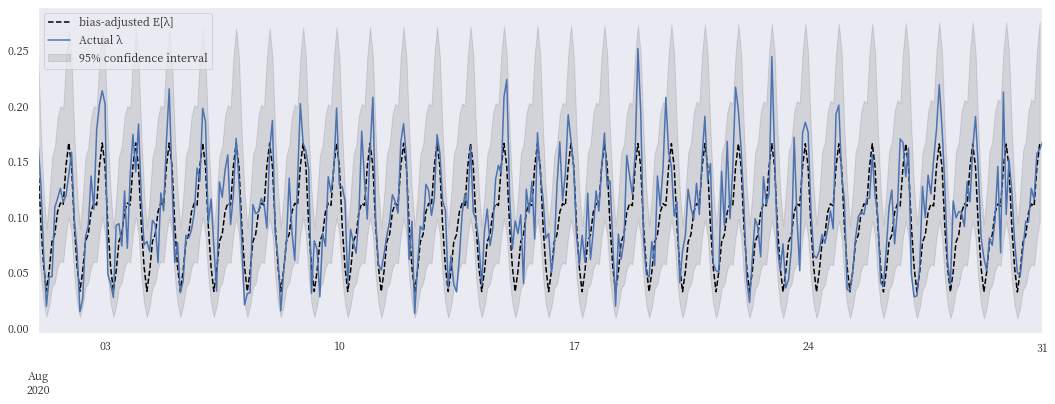

In [258]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6) )

bt = 1/backtransformed_mean(
    fc.predicted_mean, fc.var_pred_mean, slamb)

bt.plot(ax=ax, style='--', color='black', label='bias-adjusted E[λ]')
lower_bt = 1/backtransformed_mean(fc.summary_frame().mean_ci_lower, 0, slamb)
upper_bt = 1/backtransformed_mean(fc.summary_frame().mean_ci_upper, 0, slamb)

ax.fill_between(
    fc.predicted_mean.index,
    lower_bt,
    upper_bt, color='black', alpha=0.1,
    label='95% confidence interval'
);

true_rate.plot(ax=ax)

legend = plt.legend(loc='upper left')
legend.get_texts()[1].set_text('Actual λ')
month_str = upto_date.strftime("%b_%Y").lower()
fig.savefig(f'img/pred_arrival_rate_{month_str}_uncl.png',
    dpi=300, bbox_inches='tight'
)

In [ ]:
df_inv.columns

In [ ]:
df_inv[
    (df_inv['startDateTime']>=datetime.datetime(2020, 5, 19)) &
    (df_inv['startDateTime']<datetime.datetime(2020, 5, 20))]['helpseeker_alias'].value_counts().head(10)

In [ ]:
df_inv[
    (df_inv['startDateTime']>datetime.datetime(2020, 5, 19)) &
    (df_inv['startDateTime']<datetime.datetime(2020, 5, 20))]['identifier'].value_counts().head(10)

In [ ]:
s2 = true_rate.reset_index()

In [ ]:
# s2[s2['y']>=0.53387]['index'].values#[0]

In [ ]:
# s2[s2['y']>=0.15]['index'].values#[0]

In [ ]:
df_inv[df_inv['startDateTime_floor']==s2[s2['y']>=0.15]['index'].values[0]]['identifier'].value_counts()

In [ ]:
s2

In [ ]:
keep = df_inv.join(true_rate, on='startDateTime_floor').dropna(subset=['y'])

In [ ]:
keep.columns

In [ ]:
true

In [ ]:
bt

In [ ]:
true_rate

In [ ]:
sorted_by_identifier = df_inv.sort_values(by=['identifier', 'startDateTime'], ascending=True)
sorted_by_helpseeker_alias = df_inv.sort_values(by=['helpseeker_alias', 'startDateTime'], ascending=True)

In [ ]:
sorted_by_identifier['startDateTime_shift'] = sorted_by_identifier.groupby(['identifier'])['startDateTime'].shift(1)

In [ ]:
sorted_by_identifier['startDateTime_shift'].fillna(sorted_by_identifier['startDateTime'], inplace=True)

In [ ]:
sorted_by_identifier['interarrival_time'] = sorted_by_identifier['startDateTime'] - sorted_by_identifier['startDateTime_shift']

In [ ]:
sorted_by_identifier['interarrival_time'] = sorted_by_identifier['interarrival_time'] / np.timedelta64(1, 'm')

In [ ]:
sorted_by_identifier = sorted_by_identifier[sorted_by_identifier['interarrival_time']>0].copy()

In [ ]:
tc = []
for i in range(24):
    test_cases = sorted_by_identifier[(1/sorted_by_identifier['interarrival_time']>bt.iloc[i]) & 
        (sorted_by_identifier['startDateTime']>=datetime.datetime(2020, 11, 1)) &
        (sorted_by_identifier['hour']==i)
    ].copy()
    tc.append(test_cases)

In [ ]:
pd.concat(tc).groupby([
    'identifier', 'helpseeker_alias']).count().sort_values(
    '_id', ascending=False)[['_id']].rename(columns={'_id': 'count'}).to_csv('repeated_user2.csv')

In [ ]:
sorted_by_helpseeker_alias['helpseeker_alias'] = sorted_by_helpseeker_alias['helpseeker_alias'].str.lower().str.strip()

In [ ]:
sorted_by_helpseeker_alias['startDateTime_shift'] = sorted_by_helpseeker_alias.groupby(
    ['helpseeker_alias'])['startDateTime'].shift(1)

In [ ]:
sorted_by_helpseeker_alias['startDateTime_shift'].fillna(
    sorted_by_helpseeker_alias['startDateTime'], inplace=True)

In [ ]:
sorted_by_helpseeker_alias['interarrival_time'] = sorted_by_helpseeker_alias['startDateTime'] - sorted_by_helpseeker_alias['startDateTime_shift']

In [ ]:
sorted_by_helpseeker_alias['interarrival_time'] = sorted_by_helpseeker_alias['interarrival_time'] / np.timedelta64(1, 'm')

In [ ]:
sorted_by_helpseeker_alias = sorted_by_helpseeker_alias[sorted_by_helpseeker_alias['interarrival_time']>0].copy()

In [ ]:
tc = []
for i in range(24):
    test_cases = sorted_by_helpseeker_alias[(1/sorted_by_helpseeker_alias['interarrival_time']>bt.iloc[i]) & 
        (sorted_by_helpseeker_alias['startDateTime']>=datetime.datetime(2020, 11, 1)) &
        (sorted_by_helpseeker_alias['hour']==i)
    ].copy()
    tc.append(test_cases)

In [ ]:
pd.concat(tc).groupby([
    'helpseeker_alias', 'identifier']).count().sort_values(
    ['_id'], ascending=False)[['_id']].rename(columns={'_id': 'count'}).to_csv('repeated_user3.csv')

In [ ]:
res_f.plot_diagnostics(figsize=(15, 15))
plt.show()

# Time Series Cross validation

# root mean square error

# export interarrivals

In [ ]:
df_risklevels = df_risklevels[
    df_risklevels['startDateTime']>=datetime.datetime(2020, 9, 1)].copy()

In [ ]:
interarrivals_week_hour = df_risklevels.groupby(
    ['day_of_week', 'hour']).mean()[
    ['interarrival_time']].reset_index()
# interarrivals_week_hour = df_risklevels.groupby(
#     ['hour']).mean()[['interarrival_time']].join(
#     df_risklevels.groupby(['hour']).std()[
#         ['interarrival_time']], rsuffix='_std').reset_index()

interarrivals_week_hour

# 5. generate probabilities: probability accepting TOS, or `P(TOS)` then, `P(not TOS)` = 1-`P(TOS)`

In [ ]:
probs = (df_risklevels.groupby(
    ['day_of_week', 'hour','tos_status' ])[['_id']].count()/df_risklevels.groupby(
    ['day_of_week', 'hour' ])[['_id']].count()).reset_index()

# probs = (df_risklevels.groupby(
#     ['hour','tos_status' ])[['_id']].count()/df_risklevels.groupby(
#     ['hour' ])[['_id']].count()).reset_index()

In [ ]:
probs.rename(columns={'_id':'probability'}, inplace=True)

In [ ]:
probs = probs[probs['tos_status']=='accepted'].reset_index(drop=True)

In [ ]:
interarrivals_week_hour = interarrivals_week_hour.join(
    probs.set_index(['day_of_week', 'hour']),
    on=['day_of_week', 'hour'])
# interarrivals_week_hour = interarrivals_week_hour.join(probs.set_index(['hour']), on=['hour'])

In [ ]:
interarrivals_week_hour

# sort interarrivals by day and hour

In [ ]:
interarrivals_week_hour['day_int'] = interarrivals_week_hour['day_of_week'].map({
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7,
})

In [ ]:
interarrivals_week_hour.sort_values(['day_int', 'hour']).set_index(
    ['day_of_week', 'hour']).drop(columns=['day_int', 'tos_status']).to_csv(
    'interarrivals_day_of_week_hour/Sep2020_to_Nov2020/interarrivals_day_of_week_hour.csv')
# interarrivals_week_hour.drop(columns=['tos_status']).to_csv(
#     'interarrivals_day_of_week_hour/Sep2020_to_Nov2020/interarrivals_hour.csv')

# generate Nov 2020 interarrivals

In [ ]:
df_risklevels = df_risklevels[
    df_risklevels['startDateTime']>=datetime.datetime(2020, 11, 1)].copy()

In [ ]:
df_risklevels['interarrival_time'].to_csv(
    'real_interarrivals_nov.csv',
    index=False, header=False)

# breakdown graph

In [ ]:
from graphviz import Digraph

In [ ]:
breakdown = df_risklevels.groupby(['tos_status'])['_id'].count()

In [ ]:
valid_breakdown =  df_risklevels[
    df_risklevels['tos_status']=='accepted'].groupby(['incoming'])['_id'].count()

In [ ]:
num_total = len(df_risklevels)
num_tos_rejected = breakdown['not_accepted']
num_tos_accepted = breakdown['accepted']
num_valid = valid_breakdown['valid-case']
num_invalid = valid_breakdown['invalid-case']

In [ ]:
# create directed graph

fontname = 'TeX Gyre Heros'

g = Digraph(name='counsellor_dropout_highlight', format='png')

g.attr(rankdir='LR', size='10,8')
g.attr('node', **{'width':str(1.5), 'height':str(1.5)}, 
    shape='circle',
    fontname=fontname
)

g.attr('edge', fontname=fontname)




# root node
g.node('incoming', f'Incoming\n\nN={num_total}')

# level 1
g.node('TOS_accepted', f'TOS\nAccepted\n\nn={num_tos_accepted}')
g.node('TOS_rejected', f'TOS\nRejected\n\nn={num_tos_rejected}')

# level 2
g.node('valid', f'Valid\nCases\n\nn={num_valid}')
g.node('invalid', f'Invalid\nCases\n\nn={num_invalid}')



# root edges
g.edge('incoming', 'TOS_accepted',
    label=f'p={(num_tos_accepted/num_total):.02f}')
g.edge('incoming', 'TOS_rejected',
    label=f'p={(num_tos_rejected/num_total):.02f}')

# level 1 edges
g.edge('TOS_accepted', 'valid',
    label=f'p={(num_valid/num_tos_accepted):.02f}')
g.edge('TOS_accepted', 'invalid',
    label=f'p={(num_invalid/num_tos_accepted):.02f}')


g

In [ ]:
g.render('img/incoming_case_breakdown')